# Miniproject 2: Melody generation

## Introduction

### Description

To develop a model employing ANN on real-world data requires going through several major steps, each of which with important design choices that directly impact the end results. In this project, we guide you through these choices starting from a large database of [Irish folk melodies](https://github.com/IraKorshunova/folk-rnn/tree/master/data) to your own model of symbolic music composition. 


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "recurrent neural networks", "LSTM", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will be guided through a data processing procedure and understand the importance of design choices in ANN modeling
- You will learn how to define recurrent neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "overfitting", "LSTM network", and "Generative model".
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook. Please ensure that your notebook is fully executed before handing it in. 

## Functions and imports

For your convenience we import some libraries and provide some functions below. Some libraries (`midi` and `music21==5.1.0`) should be added. If you work with the docker image, pull it `docker pull zifeo/artificial-neural-networks:cpu` before to get the latest version where these libraries are added and stop/relaunch the container (as stated in the instructions https://github.com/zifeo/artificial-neural-networks). If you work locally, be sure to import them. If you do not find the midi library for python3, install it with `python setup.py install` inside the `python3-midi` folder after cloning https://github.com/louisabraham/python3-midi.git.

Finally, fill in your sciper number(s) for the random seed and simply run the following cell.

In [2]:
#project was done in collaboration with nikita lazarev (268769), however it was mostly exchange of ideas and not so much code!

sciper = {'student_1': 268578, 
          'student_2': 0}
seed = sciper['student_1']+sciper['student_2']

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os, sys

plt.rcParams['font.size'] = 28
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
c = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.figsize'] = 8, 4

import keras
from keras.models import Model, load_model
from keras.layers import Input, Masking, TimeDistributed, Dense, Concatenate, Dropout, LSTM, GRU, SimpleRNN
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
import keras.backend as K
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

import midi
import music21
import pickle

Using TensorFlow backend.


In [3]:
def plotMelody(P, T, dictionaries, PrP=None, PrT=None, H=None):
    """
    P: The pitch array (integer representation) or matrix (one-hot encoding)
    T: The duration array (integer representation) or matrix (one-hot encoding)
    dictionaries: The dictionaries relating integer to a pitch or duration
    PrP: (Optional) If provided with PrT, plot the transition probabilities
    PrT: (Optional) If provided with PrP, plot the transition probabilities
    H: (Optional) Add a plot with the hidden state dynamic sorted by frequency
    """
    P = np.asarray(P)
    T = np.asarray(T)
    if len(P.shape) == 1:#if array
        P = np_utils.to_categorical(P, len(dictionaries['P']))
    if len(T.shape) == 1:#if array
        T = np_utils.to_categorical(T, len(dictionaries['T']))
  
    xlim = [-1,np.where(P==1)[0][-1]+1]
    
    activeidxes = np.where(np.sum(P, axis=0)>1.)[0]
    plt.figure(figsize=(8,4))
    if PrP is not None:
        targets = np.where(P[:,activeidxes]==1)
        plt.imshow(PrP[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
        plt.scatter(targets[0]-1,targets[1], color='red',s=10, marker='.') 
    else:
        plt.imshow(P[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
    plt.ylim([-0.5,len(activeidxes)-0.5])
    plt.yticks(range(len(activeidxes)),[dictionaries["P"][i] for i in activeidxes])
    plt.tight_layout()
    plt.xlabel("$n$")
    plt.ylabel("$P[n]$")
    plt.xlim(xlim)
    plt.show()
    
    activeidxes = np.where(np.sum(T, axis=0)>1.)[0]
    plt.figure(figsize=(8,4))
    if PrT is not None:
        targets = np.where(T[:,activeidxes]==1)
        plt.imshow(PrT[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
        plt.scatter(targets[0]-1,targets[1], color='red',s=10, marker='.')
    else:
        plt.imshow(T[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
    plt.ylim([-0.5,len(activeidxes)-0.5])
    plt.yticks(range(len(activeidxes)),[dictionaries["T"][i] for i in activeidxes])
    plt.tight_layout()
    plt.xlabel("$n$")
    plt.ylabel("$T[n]$")
    plt.xlim(xlim)
    plt.show()
    
    if H is not None:
        diff = np.mean([[abs(j-i) for i,j in zip(H[:xlim[1]-1,k], H[1:xlim[1],k])] for k in range(H.shape[1])], axis=1)
        sortidx = np.argsort(-diff)
        H = H[:,sortidx]
        plt.figure(figsize=(8,4))
        plt.imshow(H.T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.seismic, vmin=-1, vmax=1)
        plt.xlim([-1,np.where(T==1)[0][-1]+1])
        plt.tight_layout()
        plt.xlabel("$n$")
        plt.ylabel("$H[n]$")
        plt.show()


def plotLearningCurves(*History, labels=[""]):

    compare = len(History)>1
    plt.figure(figsize=(8,4))
    color_index = 0
    for i, h in enumerate(History):
        log = h.history
        if not compare: plt.plot(log['YP_loss'], '--', c=c[color_index], label=labels[i]+'Pitch train loss')
        plt.plot(log['val_YP_loss'], c=c[color_index], label=labels[i]+'Pitch val loss')

        if not compare: plt.plot(log['YT_loss'], '--', c=c[color_index+1], label=labels[i]+'Dur train loss')
        plt.plot(log['val_YT_loss'], c=c[color_index+1], label=labels[i]+'Dur val loss')
        plt.legend(loc='best')
        color_index+=2

    color_index = 0
    plt.figure(figsize=(8,4))    
    for i, h in enumerate(History):
        log = h.history
        if not compare: plt.plot(log['YP_acc'], '--', c=c[0], label=labels[i]+'Pitch train acc')
        plt.plot(log['val_YP_acc'], c=c[color_index], label=labels[i]+'Pitch val acc')

        if not compare: plt.plot(log['YT_acc'], '--', c=c[1], label=labels[i]+'Dur train acc')
        plt.plot(log['val_YT_acc'], c=c[color_index+1], label=labels[i]+'Dur val acc')
        plt.legend(loc='best')
        color_index+=2

def sample(preds, temperature=1.):
    """Helper function to sample an index from a probability array"""
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def writeMIDI(xP, xT, dictionaries, label):

    # Instantiate a MIDI Pattern (contains a list of tracks)
    pattern = midi.Pattern(format = 0, resolution=480)
    # Instantiate a MIDI Track (contains a list of MIDI events)
    track = midi.Track()
    # Append the track to the pattern
    pattern.append(track)
    Events = []
    
    pseq = [dictionaries['P'][p] for p in xP]
    tseq = [dictionaries['T'][t] for t in xT]
    for t, p in zip(tseq, pseq):
        e = midi.NoteOnEvent(tick=0, velocity=90, pitch=p)
        track.append(e)
        e = midi.NoteOffEvent(tick=t, velocity=0, pitch=p)
        track.append(e)
        
    eot = midi.EndOfTrackEvent(tick=1)
    track.append(eot)
    # Save the pattern to disk
    midi.write_midifile(label, pattern)

## Exercise 1 : Data processing
### Description

For a real world application of ANNs, the original data should be translated into a representation understandable by an ANN. This step is often neglected but is of outmost importance. In order for you to better understand how ANN are applied to real world problems, the first step of this miniproject will guide you through a possible representation. 

Note that in general, your representation should be normalized in order to obtain homogeneous data from which a structure can be extracted by your ANN model. Importantly, all processing steps toward your representation should not (or minimally) distort your original data.

To represent MIDI files, we provide you with a Python MIDI library. You should then

0. Download the MIDI tar file from [this link](https://github.com/IraKorshunova/folk-rnn/tree/master/data) and put it in a folder named "chorpus" at the same level of this notebook.
1. Parse the chorpus to extract the label of (a random subset of) the data (code is provided)
2. Read each MIDI file in the subset with the midi [library](https://github.com/louisabraham/python3-midi)
3. For each data sequence extract the sequence of MIDI notes defined by two dimensions ("P": the sequence of note pitches (integer between 0 and 127 representing a piano key), "T": the sequence of note durations.
4. Select two melodies and display them both as sequences of MIDI events and sequence of notes in two dimensions. Control that your representation is correct.

For step 3, you should learn how MIDI files are constructed. Below, we give a minimal explanation and some code for this particular project. For a more complete explanation, look for MIDI in your favorite search engine. Given this dataset, you can observe that it is monophonic (one note at a time) and there's a small delay (1 tick) inbetween each note. You could decide to ignore this delay or correct (recommanded) for it.

A MIDI files is composed of timed events of many kinds. For this project, we focus on the events related to notes being played or stopped. Those are MIDI events "Note Off" and "Note On". Each event is timed with respect with the previous one (dt). The duration of a note is therefore given by the cummulated dt inbetween the event associated to a note's onset and the event associated with the same note's offset.
        

### Minimal code to read MIDI files

In [3]:
def display(midi_file="chorpus/sessiontune0.mid"):
    #index 0 for first track only
    events = midi.read_midifile(midi_file)[0] 
    tick = 0
    print(midi_file)
    print("#"*40)
    print("tick \t pitch \t message \t velocity")
    print("#"*40+'\n')
    for n, event in enumerate(events):
        tick += event.tick
        if event.name in ['Note On', 'Note Off']:
            if n<13 or n>len(events)-10:
                print("%i \t %i \t %s \t %i"%(tick, event.data[0], event.name, event.data[1]))
            if n in range(20,23):
                print(". \t . \t . \t \t .")
    print("#"*40+'\n')

display()

datapath = "chorpus/"
dataset = {}
np.random.seed(seed)

for filename in os.listdir(datapath):
    if filename.endswith("mid"):
        label = filename[:-4]
        #Down sample dataset
        if np.random.rand() < 0.1:
            dataset[label] = {"T":[], "P": []}
print("%i/%i melodies retained"%(len(list(dataset.keys())), len(os.listdir(datapath))))

chorpus/sessiontune0.mid
########################################
tick 	 pitch 	 message 	 velocity
########################################

1 	 67 	 Note On 	 105
240 	 67 	 Note Off 	 0
241 	 64 	 Note On 	 80
480 	 64 	 Note Off 	 0
481 	 64 	 Note On 	 80
720 	 64 	 Note Off 	 0
721 	 64 	 Note On 	 95
1200 	 64 	 Note Off 	 0
1201 	 62 	 Note On 	 80
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
33601 	 67 	 Note On 	 80
33840 	 67 	 Note Off 	 0
33841 	 69 	 Note On 	 95
34080 	 69 	 Note Off 	 0
34081 	 71 	 Note On 	 80
34320 	 71 	 Note Off 	 0
34321 	 72 	 Note On 	 80
34560 	 72 	 Note Off 	 0
########################################

4675/45853 melodies retained


### Solution

In [4]:
def parseMIDI(midi_file):
    events = midi.read_midifile(midi_file)[0] #index 0 for first track only  
    T = []
    P = []
    for n, event in enumerate(events):
        if event.name == 'Note On':
            P.append(event.data[0])
        if event.name == 'Note Off':
            T.append(event.tick +1)
    return P, T

for label in list(dataset.keys()):
    Pseq, Tseq = parseMIDI(datapath+label+".mid")
    dataset[label]['T']= Tseq
    dataset[label]['P']= Pseq

for label in np.random.choice(list(dataset.keys()), 2):
    print(label)
    print("MIDI events")
    display(datapath+label+".mid")
    print("Note representation")
    print(dataset[label])
    print('/n')


sessiontune26643
MIDI events
chorpus/sessiontune26643.mid
########################################
tick 	 pitch 	 message 	 velocity
########################################

1 	 75 	 Note On 	 105
240 	 75 	 Note Off 	 0
241 	 73 	 Note On 	 80
480 	 73 	 Note Off 	 0
481 	 72 	 Note On 	 105
720 	 72 	 Note Off 	 0
721 	 68 	 Note On 	 80
960 	 68 	 Note Off 	 0
961 	 70 	 Note On 	 80
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
60241 	 68 	 Note On 	 80
60480 	 68 	 Note Off 	 0
60481 	 68 	 Note On 	 80
60720 	 68 	 Note Off 	 0
60721 	 67 	 Note On 	 80
60960 	 67 	 Note Off 	 0
60961 	 68 	 Note On 	 95
61440 	 68 	 Note Off 	 0
########################################

Note representation
{'T': [240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 480, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 480, 240, 240, 240, 720, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240,

## Exercise 2: Tokenzation and translation to integer
### Description

Now you should have a "dataset" dictionary where each entry corresponds to one melody example from a subset of the full dataset. In turn, every melody example is represented by a dictionary with two sequences: the "P" entry being the sequence of pitches and the "T" entry, the sequence of durations. Here, you will implement the first steps to translate this dataset in a language that can be read by your ANN models. To achieve that, we will later use the [one-hot encoding scheme](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/), which will associate each input (and output) unit of your network to a unique pitch or duration. In your network, these units will then be sequentially activated in the same order as their corresponding pitch/duration in your dataset. And at each note, the model will be trained to approximate the probability distributions of the upcoming pitch and duration.

1. Gather in a list of all possible pitches and durations in your dataset. These two lists will be your "dictionaries" translating a pitch/duration to a unique integer between 0 and the number of entries (-1) in the pitch/duration dictionary.
2. Translate the pitch/duration sequence of each melody to the integer representation.
3. Select randomly two melodies and display them in the note representation and translated to integer. Check that the translation is correct.

### Solution

#### Map values to integer and translate songs to integer representation

In [5]:
import copy
def map_values(dataset):
    dict_P= []
    dict_T=[]
    for i, values in enumerate(list(dataset.values())):
        dict_P = list(set(dict_P+values['P']))
        dict_T = list(set(dict_T+values['T']))
    dict_P_map = dict(zip(dict_P, range(len(dict_P))))
    dict_T_map = dict(zip(dict_T, range(len(dict_T))))
    return dict_P_map, dict_T_map

def translate_songs(dataset, dict_P_map, dict_T_map):
    dataset_int = copy.deepcopy(dataset)
    for label in dataset:
        dataset_int[label]['P']=list(map(lambda x: dict_P_map[x], dataset[label]['P']))
        dataset_int[label]['T']= list(map(lambda x: dict_T_map[x], dataset[label]['T']))
    return dataset_int

def tokenization(dataset):
    dict_P_map, dict_T_map = map_values(dataset)
    dataset_int = translate_songs(dataset, dict_P_map, dict_T_map)
    return dataset_int, dict_P_map, dict_T_map

dataset_int, _, _ = tokenization(dataset)

#### Display 2 random songs in both formats

In [6]:
for label in np.random.choice(list(dataset.keys()), 2):
    print(label)
    print("Note representation")
    print(dataset[label], '\n')
    print("Integer representation")
    print(dataset_int[label], '\n')

sessiontune26108
Note representation
{'T': [240, 240, 240, 240, 240, 480, 120, 120, 120, 120, 120, 120, 120, 120, 240, 240, 240, 240, 240, 240, 120, 120, 120, 120, 120, 120, 240, 240, 240, 480, 120, 120, 240, 240, 240, 480, 120, 120, 120, 120, 120, 120, 120, 120, 240, 240, 240, 240, 240, 240, 120, 120, 120, 120, 120, 120, 240, 240, 240, 480, 240, 240, 240, 240, 240, 480, 120, 120, 120, 120, 120, 120, 120, 120, 240, 240, 240, 240, 240, 240, 120, 120, 120, 120, 120, 120, 240, 240, 240, 480, 120, 120, 240, 240, 240, 480, 120, 120, 120, 120, 120, 120, 120, 120, 240, 240, 240, 240, 240, 240, 120, 120, 120, 120, 120, 120, 240, 240, 240, 480, 240, 240, 240, 240, 240, 480, 120, 120, 240, 240, 240, 480, 120, 120, 320, 160, 240, 320, 160, 240, 240, 240, 240, 480, 120, 120, 240, 240, 240, 320, 160, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 120, 120, 120, 120, 120, 120, 240, 240, 240, 480, 240, 240, 240, 240, 240, 480, 120, 120, 240, 240, 240, 480, 120, 120, 320, 160, 240, 320, 160, 240, 2

## Exercise 3: Data reprocessing
### Description

Before moving to the implementation of your RNN generative model of note transition, you will perform data exploration and modification. This step will allow your model to get the most out of your original data as well as ensuring some features such as transposition invariance. 

To further improve your model, you might want to reconsider your original data. Many different approaches can be undertaken. Here you are asked to implement the a rare event suppression method and transposition invariance.

**Rare event suppression** If a unit in your network is associated to a duration that happens very rarely in your data, a possible simplification consists in removing the melodies conaining these rare events from your dataset. 
1. Plot and comment the histogram of durations in your entire dataset. Use the labels from the original duration values (rather than the integer representation). 
2. Based on your observations, remove from your dataset melodies containing very rare durations. Adjust the rejection threshold such that at most 5% of the melodies are dicarded with this step. 
3. Recompute the duration dictionary based on your filtered dataset and plot the new histogram of durations. 

**Transposition invariance** A melody is perceived similarly by the human ear if it's shifted up or down by a constant offset (see [transposition](https://en.wikipedia.org/wiki/Transposition_(music))). Here, you will force your model to be transposition invariant. For this you can choose to use one of two orthogonal methods. The first consists in transposing every melody into a common tonality (C Major/A minor). On the other hand, the second consists in transposing each melody in all possible keys. The second method will increase your dataset size by a factor bigger than 11! As the training time is directly related with the dataset size, to save computing time, we recomand that you implement the first option.

***Pitch normalization*** 
1. Use the provided function to create a new dataset where all melodies are transposed to C Major/A minor. 
2. Plot the histograms of the pitches before and after transposition.

Finally, you shoud recompute the tokenization step for your brand new filtered and normalized dataset.

### Solution

#### Plot histogram with tone durations

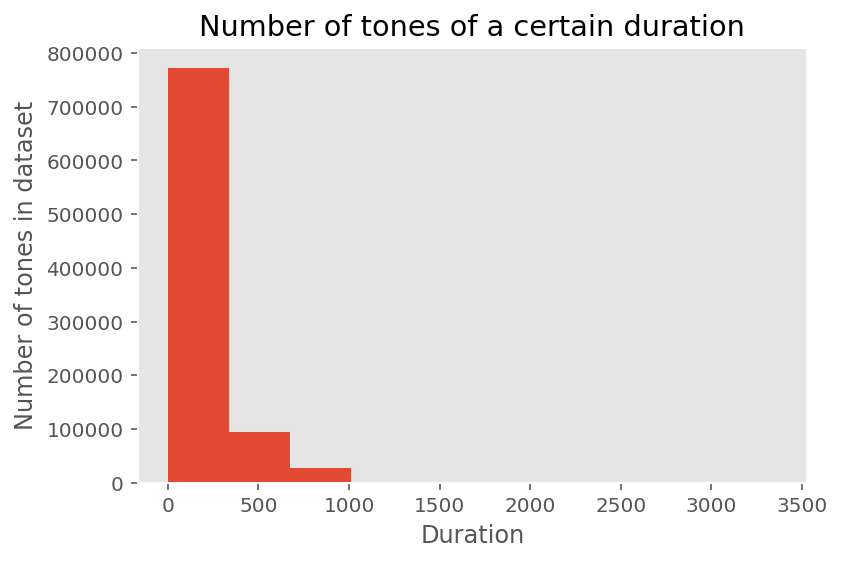

In [7]:
def plot_histogram_T(dataset):
    all_T = sum([x['T'] for x in list(dataset.values())], [])
    plt.hist(all_T)
    plt.ylabel("Number of tones in dataset")
    plt.xlabel("Duration")
    plt.title("Number of tones of a certain duration")
    return all_T
all_T = plot_histogram_T(dataset)

#### Delete songs with rare durations

In [8]:
from collections import Counter
import operator
T_cnt = Counter(all_T)
T_all_sorted = list(sorted(T_cnt.items(), key=operator.itemgetter(1)))

In [9]:
def count_songs(t, dataset):
    cnt = 0
    songs = []
    for label in dataset:
        if t in dataset[label]['T']: 
            cnt+=1
            songs.append(label)
    return cnt, songs

In [10]:
THRESHOLD = int(0.05*len(dataset))
k = -1
num_songs = 0
del_songs = []
while num_songs<THRESHOLD:
    k+=1
    for s in del_songs: dataset.pop(s, None)
    num_songs_t, del_songs =count_songs(T_all_sorted[k][0], dataset)
    num_songs+=num_songs_t          

#### Plot new histogram with tone durations

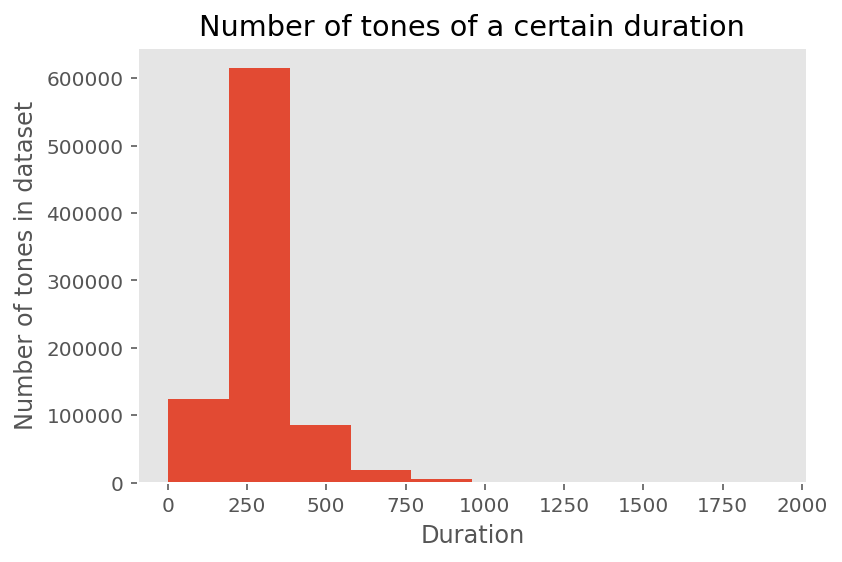

In [12]:
all_T = plot_histogram_T(dataset)

#### Transpose dataset

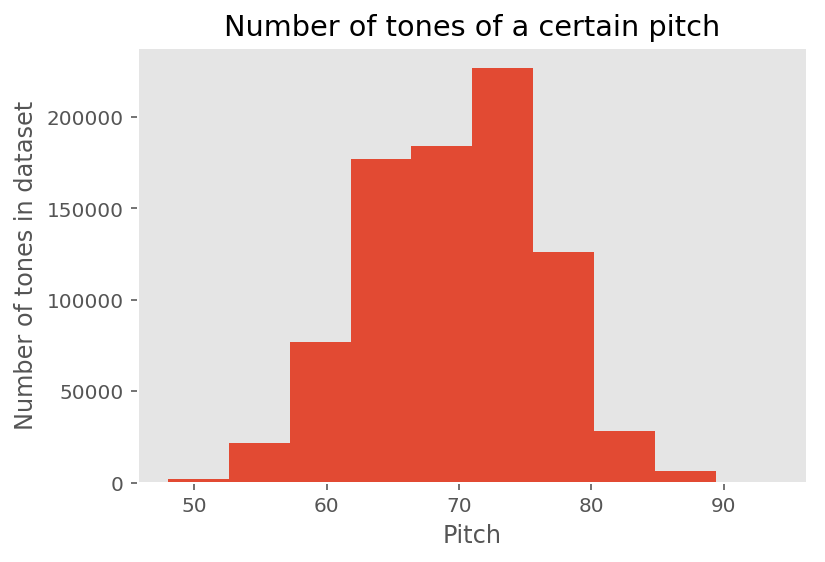

In [13]:
def plot_histogram_P(dataset):
    all_P = sum([x['P'] for x in list(dataset.values())], [])
    plt.hist(all_P)
    plt.ylabel("Number of tones in dataset")
    plt.xlabel("Pitch")
    plt.title("Number of tones of a certain pitch")
plot_histogram_P(dataset)

In [14]:
def transposeDataset(dataset):
    transposed_dataset = {}

    for i, label in enumerate(list(dataset.keys())):
        if i%100 ==0: print("{}/{}".format(i, len(dataset)))
        transposed_dataset[label] = {}
        score = music21.converter.parse(datapath+label+".mid")
        key = score.analyze('key')
        if key.mode == "major":
            i = music21.interval.Interval(key.tonic, music21.pitch.Pitch('C'))
        elif key.mode == "minor":
            i = music21.interval.Interval(key.tonic, music21.pitch.Pitch('A'))
        i = i.semitones
        transposed_dataset[label]['P'] = [p+i for p in dataset[label]['P']]
        transposed_dataset[label]['T'] = dataset[label]['T']
    return transposed_dataset
dataset = transposeDataset(dataset)

0/4454
100/4454
200/4454
300/4454
400/4454
500/4454
600/4454
700/4454
800/4454
900/4454
1000/4454
1100/4454
1200/4454
1300/4454
1400/4454
1500/4454
1600/4454
1700/4454
1800/4454
1900/4454
2000/4454
2100/4454
2200/4454
2300/4454
2400/4454
2500/4454
2600/4454
2700/4454
2800/4454
2900/4454
3000/4454
3100/4454
3200/4454
3300/4454
3400/4454
3500/4454
3600/4454
3700/4454
3800/4454
3900/4454
4000/4454
4100/4454
4200/4454
4300/4454
4400/4454


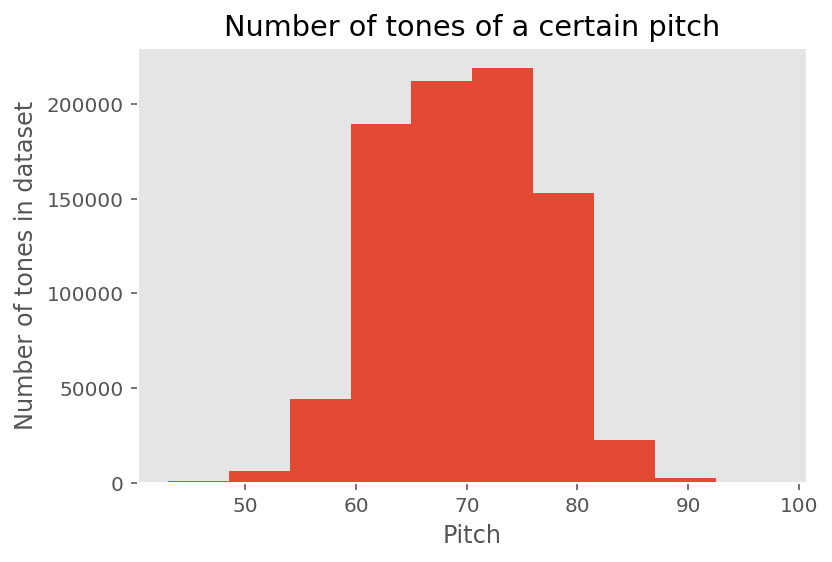

In [15]:
plot_histogram_P(dataset)

#### Dataset tokenization

In [16]:
dataset_int, dict_P_map, dict_T_map = tokenization(dataset)

**Question**: How much did you reduce the space of possible durations with your rare event suppression procedure? What is the impact in term of training time?
    
**Answer**: By applying rare event suppression, space of possible durations is reduced from 70 classes to 19 classes (almoust 75% reduction) and the dataset is reduced by about 5%. Smaller output means less parameters, therefore this will reduce training time. Furthermore, it will most surely increase accuracy of our prediction, since there are less possible classes. 

**Question**: Explain why and how both transposition to a single tonality and to all possible tonalities can yield transposition invariance in your model. 

**Answer**: By transposing to a single tonality, I normalize my data to that single tonality. On the other hand, by adding all possible tonalities for one melody, I remove the effect of different melodies being created in different tonalities (which is exactly what normalization in first part does).

**Question**: In terms of number of dimensions, what would have been the impact of keeping the joint represenation of a note duration and pitch (vs separating the two features)? 

**Answer**: Let's say that dimension of space of possible pitches is P and dimension of space of possible durations is T, then with joint representation we would have space of dimension P\*T. Therefore, we conclude that the reduction is significant.

**Question**: How would the distribution of notes in the joint representation differ from the distributions in the pitch and duration only representations (as shown by your histograms above)?

**Answer**: For this two features we have distributions which are close to Gaussian. For a distribution of notes in the joint representation I would expect Gaussian distribution as well, but much more flat (with bigger variance), since it is much less probably that few (pitch, duration) pairs are dominating (compared to solely duration, where we have few dominating durations).

## Exercise 4: One-hot and zero-padding
### Description

The last few steps to be able to feed (note by note) your music scores to a RNN model are
1. Transform the sequence of integers into a sequence of vectors in the one-hot encoding scheme.
2. Homegenize the length of each sequence

**One-hot encode** You can implement your own integer to one-hot code. For this use the numpy library and the suitable datatype. Alternatively, Keras provides a [built in one-hot encoding scheme](https://keras.io/utils/#to_categorical). After this step, for each melody, you should have two similar length matrices with one representing the sequence of note pitches and the other the sequence of note durations.
1. Code the integer representation into matrices of one-hot vectors

**Zero-padding** Most deep learning libraries, including Keras, require that you specify the shape of the input data. As such, you cannot have variable length inputs per-se. The trick to handle them is [zero-padding](https://keras.io/preprocessing/sequence/#pad_sequences). Provided with the [Masking Layer](https://keras.io/layers/core/#masking) Keras will then ignore time steps where all inputs are 0.
1. Extend the end of each melody matrices with vectors containing only zeros until all melodies have the same size. For simplicity, use the Keras pad_sequences function. There might be some rare very long melodies in your dataset, a possible choice is to set the 'maxlen' argument of pad_sequences to the mean+2std of the melody lengths. This ensure that 95% of your melodies would end before being truncated.
2. Check and display the dimension of the resulting tensors. Typically, the tensor representing the sequence of pitches should be of shape [number of melodies x number of notes x number of entries in the pitch dictionary] and the tensor representing the sequence of durations [number of melodies x number of notes x number of entries in the duration dictionary]

To check if this step was done correctly use the provided plotMelody function. For two randomly selected melodies, call the plotMelody function before and after one-hot/zero-pad. You should obtain the same plots (or slightly truncated if you randomly selected one belonging to 5% longest).

Finally, we strongly suggest that you save your preprocessed data now.

### Solution

#### Plot two random melodies 

In [17]:
lab1, lab2 = np.random.choice(list(dataset_int.keys()), 2) 
inv_dict_P_map = {v: k for k, v in dict_P_map.items()}
inv_dict_T_map = {v: k for k, v in dict_T_map.items()}
dictionaries = {'P': inv_dict_P_map, 'T':inv_dict_T_map}

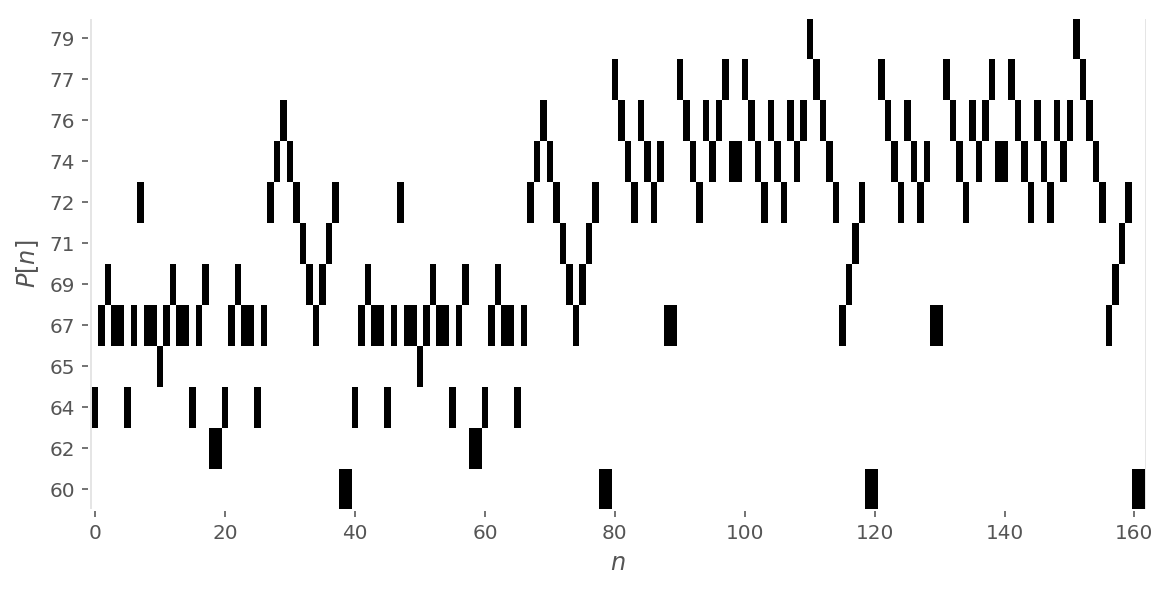

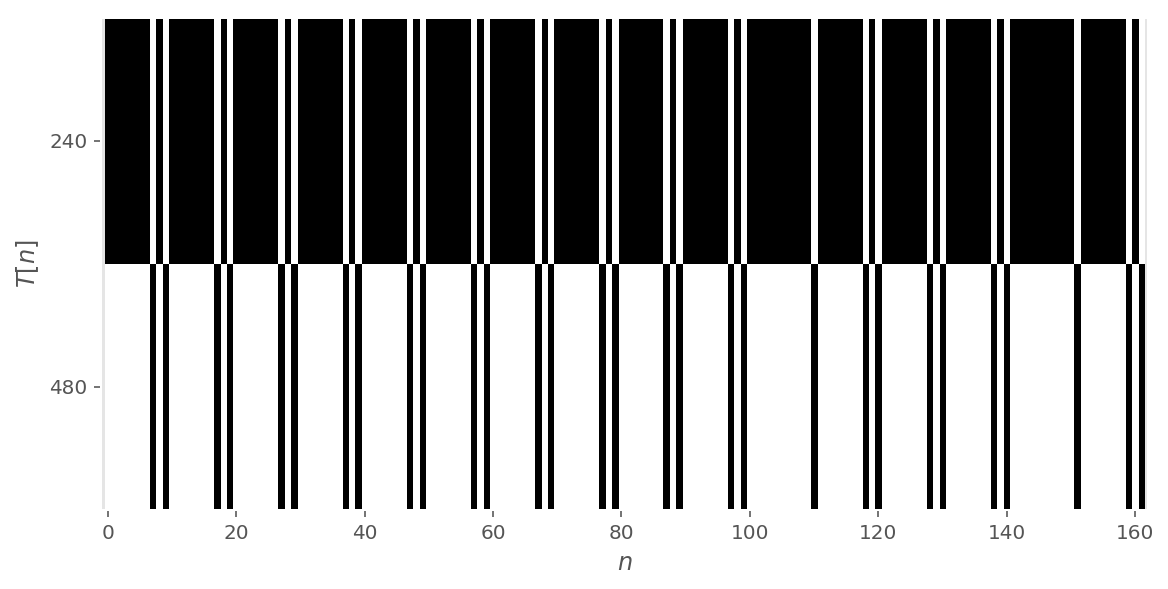

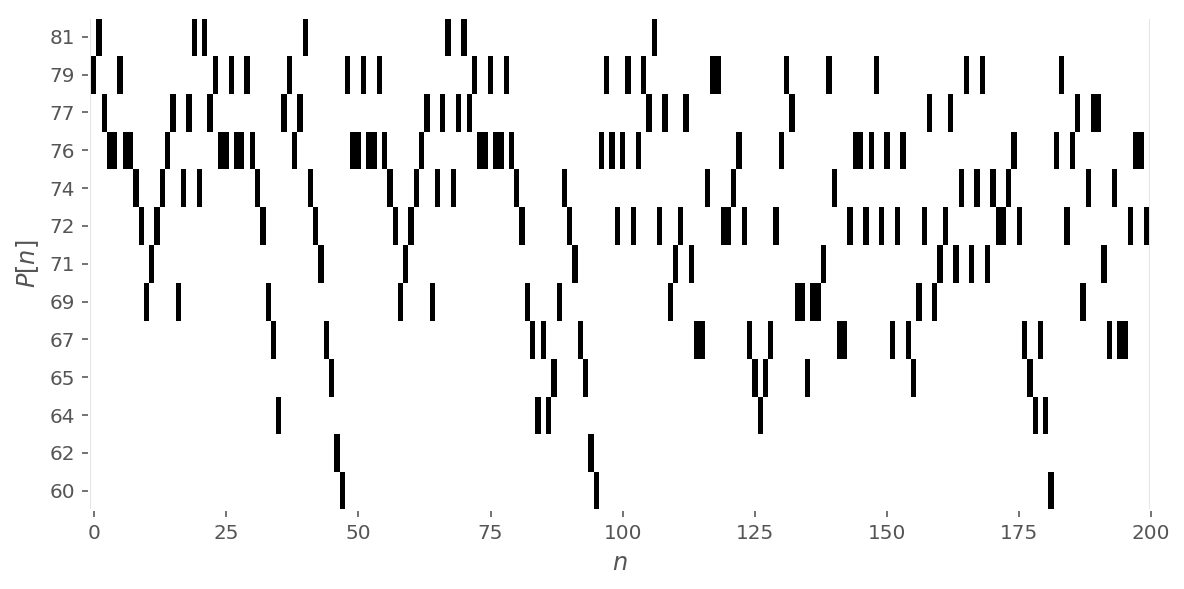

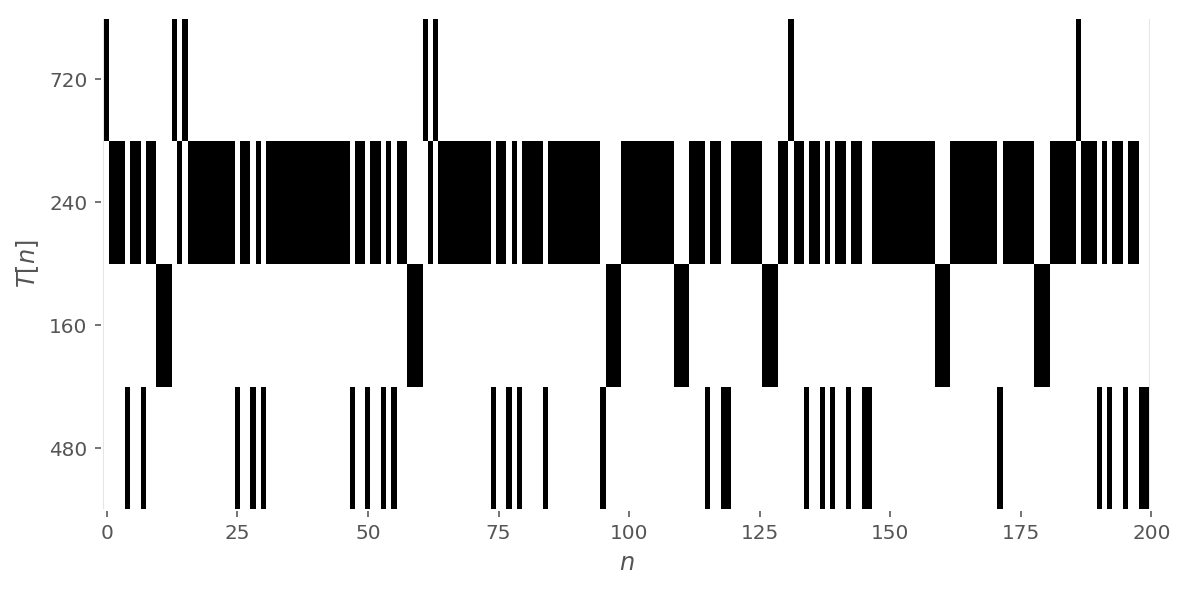

In [18]:
plotMelody(dataset_int[lab1]['P'], dataset_int[lab1]['T'], dictionaries)
plotMelody(dataset_int[lab2]['P'], dataset_int[lab2]['T'], dictionaries)

#### One-hot encoding

In [19]:
T = [[] for k in range(len(dataset_int))]
P = [[] for k in range(len(dataset_int))]
lab_ind_map = {}
for i, l in enumerate(dataset_int):
    T[i] = keras.utils.to_categorical(dataset_int[l]['T'], num_classes = len(dict_T_map))
    P[i] = keras.utils.to_categorical(dataset_int[l]['P'], num_classes = len(dict_P_map))
    lab_ind_map[l]=i

#### Zero padding

In [20]:
max_T_len =max([len(v) for v in T])
max_P_len =max([len(v) for v in P])

T_pad = pad_sequences(T, maxlen = max_T_len, padding='post')
P_pad = pad_sequences(P, maxlen = max_P_len, padding='post')

print("T padded shape is {}".format(T_pad.shape))
print("P padded shape is {}".format(P_pad.shape))

T padded shape is (4454, 1124, 19)
P padded shape is (4454, 1124, 53)


#### Zero padding, with long melodies truncated

In [21]:
T_len =[len(v) for v in T]
P_len =[len(v) for v in P]

T_pad_trunc = pad_sequences(T, maxlen = int(np.mean(T_len)+2*np.std(T_len)), padding='post', truncating='post')
P_pad_trunc = pad_sequences(P, maxlen = int(np.mean(P_len)+2*np.std(P_len)), padding='post', truncating='post')

print("T padded and truncated shape is {}".format(T_pad_trunc.shape))
print("P padded and truncated shape is {}".format(P_pad_trunc.shape))

T padded and truncated shape is (4454, 382, 19)
P padded and truncated shape is (4454, 382, 53)


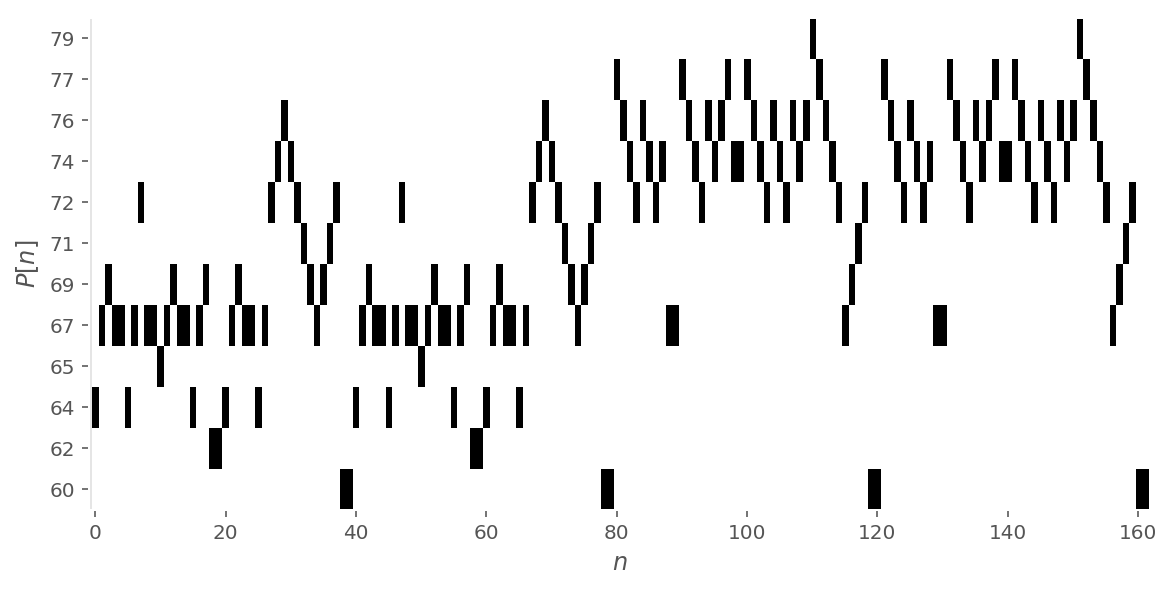

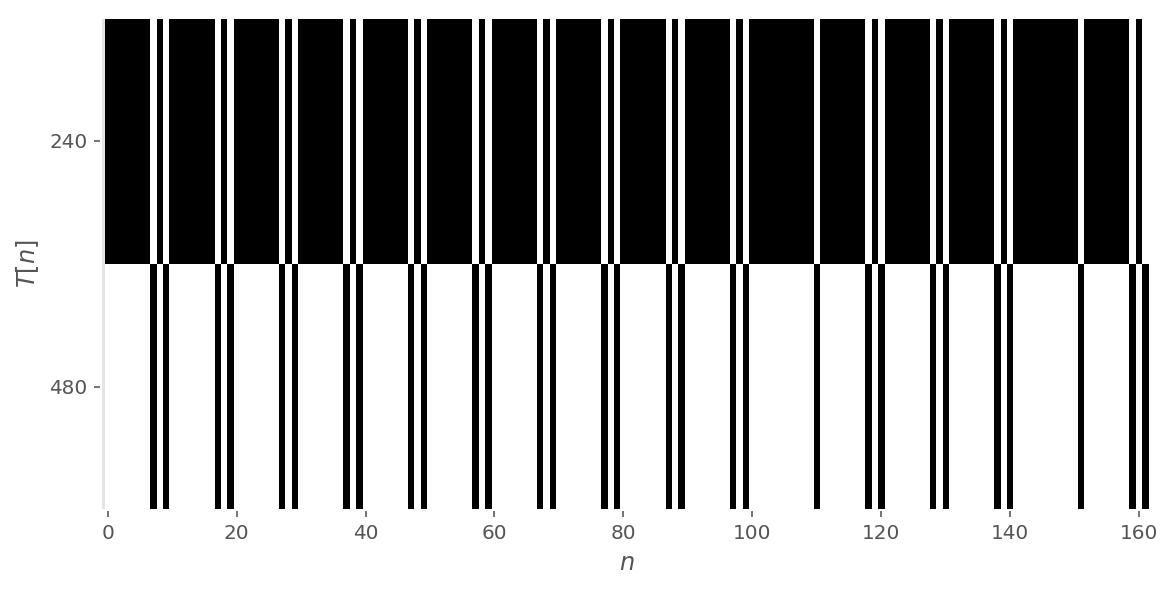

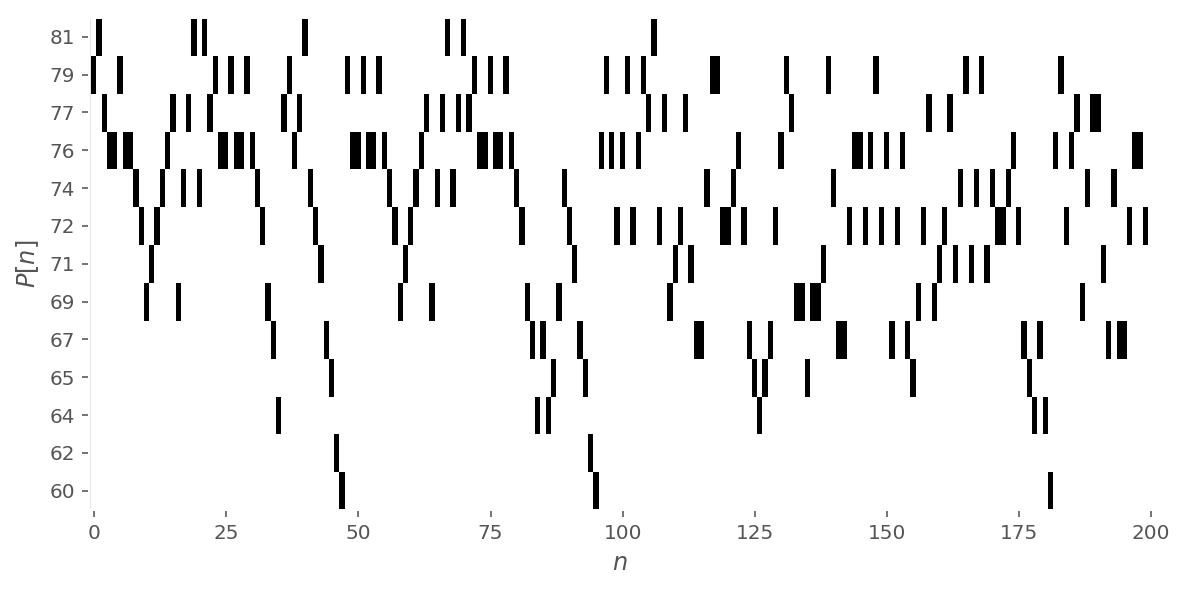

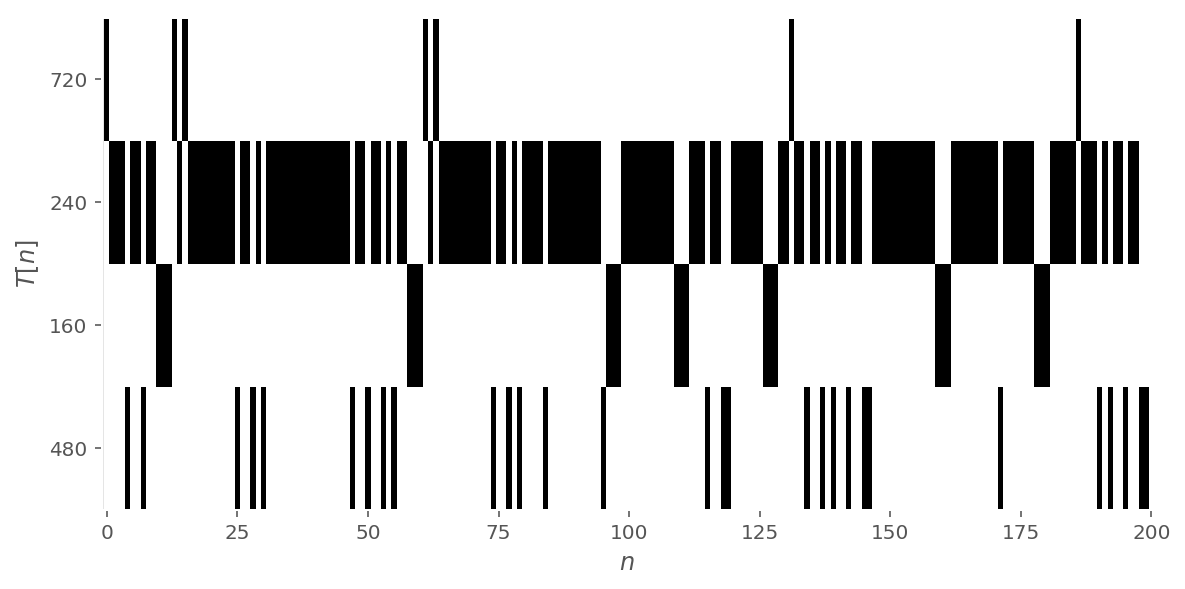

In [22]:
ind1 =lab_ind_map[lab1]
ind2 =lab_ind_map[lab2]
plotMelody(P_pad_trunc[ind1], T_pad_trunc[ind1], dictionaries) 
plotMelody(P_pad_trunc[ind2], T_pad_trunc[ind2], dictionaries)

##### Save preprocessed data

In [40]:
pickle.dump(T_pad_trunc, open('preprocessed/T_pad_trunc.p', 'wb'))
pickle.dump(P_pad_trunc, open('preprocessed/P_pad_trunc.p', 'wb'))
pickle.dump(dictionaries, open('preprocessed/dictionaries.p', 'wb'))

## Exercise 5: Building and training a generative model of  note transition with the Keras functional API
### Description

The Keras Sequential model is very efficient for fast prototyping, however suffers from a lack of design liberty. The Keras Functional API is only slightly more complex but allows for more control on the different parts of your model. You will be using the Functional API for the rest of this project. Please read carefully the [documentation](https://keras.io/getting-started/sequential-model-guide/). 

Here, you will be constructing your RNN model of note transition. To achieve that, your model should be trained to approximate the probability distribution of the upcoming note (observed as two output softmax layers - one for pitch and one for duration) given the current note (given as input) and the model internal representation of the history of notes (its hidden state). To achieve that, set the Keras RNN layer argument "return_sequences" to True when building your model. Doing this will give you an output for each note, rather than a single output at the end of the sequence. During training, the target at each time step is the next note pitch and duration.

You are free to use your own architecture but make sure to use at least 128 hidden units, Masking, and dropout to prevent overfitting. Your model should have two output (softmax) layers, one related to the pitch predictions that you should name `YP`, and the other related to the duration predictions `YT`. You should monitor both the loss (categorical_crossentropy) and the accuracy. For your best model, you should reach 40%/75% accuracy on the pitch/duration predictions.

1. Train your first model composed of SimpleRNN cells for min 250 epochs and save the model/parameters that lead to the higher accuracy on the validating set. Use a validation split of 0.2. Try  If you correctly named the output layers (`YP` and `YT`) use the provided `plotLearningCurves(History)` function to plot the learning curves by giving the History object returned by the Keras fit function as argument.  
2. Train a second model where you replaced the SimpleRNN units with GRUs (LSTM unit equivalent that requires less parameters). Make sure you use the same hyperparameters as before. Plot the learning curves.
3. On a single plot, adapt the `plotLearningCurves(History)` function to compare the validation learning curves of the simpleRNN and GRU models. In other words, plot the validation loss vs epoch for pitch/duration for the simpleRNN and GRU models. Do the same for accuracies.


### Solution

In [6]:
T_pad_trunc = pickle.load(open('preprocessed/T_pad_trunc.p', 'rb'))
P_pad_trunc = pickle.load(open('preprocessed/P_pad_trunc.p', 'rb'))
dictionaries = pickle.load(open('preprocessed/dictionaries.p', 'rb'))
num_timestamps = T_pad_trunc.shape[1]

#for Y generation
def shift_pad(x):
    return np.pad(x[:, 1:, :], [(0,0), (0, 1), (0, 0)], 'constant', constant_values=(0, 0))

#### Build model

In [26]:
def buildModel(dictionaries, batch_length, dropout=0.2, activation='GRU', Hsize=128,  N_layers = 1):
    X = dict()
    H = dict()
    M = dict()
    Y = dict()
    
    X['T'] = Input(shape=(batch_length, len(dictionaries['T'])), name="XT")
    X['P'] = Input(shape=(batch_length, len(dictionaries['P'])), name="XP")
    
    M['T'] = Masking(mask_value=0., name="MT")(X['T'])
    M['P'] = Masking(mask_value=0., name="MP")(X['P'])
    
    H['1'] = Concatenate(name="MergeX")([M['T'], M['P']])
    if activation == 'GRU':
        for i in range(2, 2+N_layers):
            H[str(i)] = GRU(Hsize, return_sequences=True)(H[str(i-1)])
    elif activation == 'LSTM':
        for i in range(2, 2+N_layers):
            H[str(i)] = LSTM(Hsize, return_sequences=True)(H[str(i-1)])
    elif activation == 'RNN':
        for i in range(2, 2+N_layers):
            H[str(i)] = SimpleRNN(Hsize, return_sequences=True)(H[str(i-1)])

    Y['T'] = TimeDistributed(Dense(len(dictionaries['T']), activation='softmax'), name='YT')(H[str(N_layers+1)])
    Y['P'] = TimeDistributed(Dense(len(dictionaries['P']), activation='softmax'), name='YP')(H[str(N_layers+1)])
    model = Model(inputs = [X['T'], X['P']], outputs = [Y['T'], Y['P']])

    opt = Adam() 
    model.compile(
        loss='categorical_crossentropy', 
        optimizer=opt,
        metrics=['acc'],
        loss_weights={'YT':0.25, 'YP':0.75})
    
    
    return model

#### Train SimpleRNN model

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
XT (InputLayer)                 (None, 382, 19)      0                                            
__________________________________________________________________________________________________
XP (InputLayer)                 (None, 382, 53)      0                                            
__________________________________________________________________________________________________
MT (Masking)                    (None, 382, 19)      0           XT[0][0]                         
__________________________________________________________________________________________________
MP (Masking)                    (None, 382, 53)      0           XP[0][0]                         
__________________________________________________________________________________________________
MergeX (Co

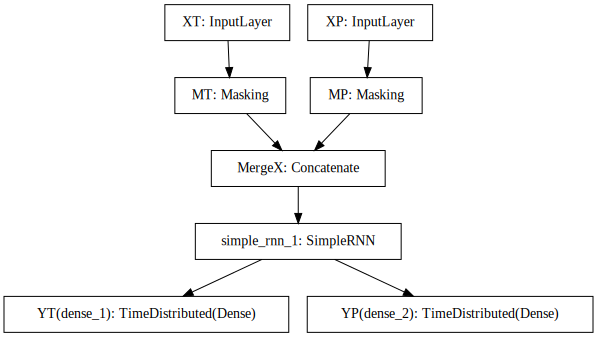

In [27]:
RNNmodel = buildModel(dictionaries, 
                      batch_length=num_timestamps,
                      activation='RNN',
                      N_layers = 1)
RNNmodel.summary()
SVG(model_to_dot(RNNmodel).create(prog='dot', format='svg'))

In [28]:
callbacks_list = [ModelCheckpoint('models/RNN_bestvalacc_1L128U_full.hdf5', monitor='val_YP_acc', save_best_only=True, mode='max')]
historyRNN = RNNmodel.fit([T_pad_trunc, P_pad_trunc], [shift_pad(T_pad_trunc), shift_pad(P_pad_trunc)], \
                       validation_split=0.2, batch_size=128, epochs=250, verbose=1, callbacks=callbacks_list)

Train on 3563 samples, validate on 891 samples
Epoch 1/250
3563/3563 [==============================] - 44s 12ms/step - loss: 2.7080 - YT_loss: 1.4782 - YP_loss: 3.1179 - YT_acc: 0.6210 - YP_acc: 0.1120 - val_loss: 2.3749 - val_YT_loss: 1.1159 - val_YP_loss: 2.7945 - val_YT_acc: 0.6870 - val_YP_acc: 0.1219
Epoch 2/250
3563/3563 [==============================] - 41s 11ms/step - loss: 2.2846 - YT_loss: 0.9963 - YP_loss: 2.7141 - YT_acc: 0.7158 - YP_acc: 0.1717 - val_loss: 2.1633 - val_YT_loss: 0.9900 - val_YP_loss: 2.5544 - val_YT_acc: 0.7285 - val_YP_acc: 0.1918
Epoch 3/250
3563/3563 [==============================] - 39s 11ms/step - loss: 2.0463 - YT_loss: 0.9297 - YP_loss: 2.4185 - YT_acc: 0.7409 - YP_acc: 0.2253 - val_loss: 1.9698 - val_YT_loss: 0.9254 - val_YP_loss: 2.3179 - val_YT_acc: 0.7449 - val_YP_acc: 0.2458
Epoch 4/250
3563/3563 [==============================] - 39s 11ms/step - loss: 1.9109 - YT_loss: 0.8781 - YP_loss: 2.2551 - YT_acc: 0.7540 - YP_acc: 0.2594 - val_loss: 1.

3563/3563 [==============================] - 55s 15ms/step - loss: 1.4957 - YT_loss: 0.6597 - YP_loss: 1.7744 - YT_acc: 0.8052 - YP_acc: 0.3776 - val_loss: 1.5168 - val_YT_loss: 0.6755 - val_YP_loss: 1.7973 - val_YT_acc: 0.8022 - val_YP_acc: 0.3711
Epoch 33/250
3563/3563 [==============================] - 55s 15ms/step - loss: 1.4942 - YT_loss: 0.6576 - YP_loss: 1.7731 - YT_acc: 0.8061 - YP_acc: 0.3786 - val_loss: 1.5150 - val_YT_loss: 0.6726 - val_YP_loss: 1.7958 - val_YT_acc: 0.8024 - val_YP_acc: 0.3723
Epoch 34/250
3563/3563 [==============================] - 59s 16ms/step - loss: 1.4933 - YT_loss: 0.6560 - YP_loss: 1.7725 - YT_acc: 0.8067 - YP_acc: 0.3785 - val_loss: 1.5188 - val_YT_loss: 0.6734 - val_YP_loss: 1.8006 - val_YT_acc: 0.8028 - val_YP_acc: 0.3716
Epoch 35/250
3563/3563 [==============================] - 54s 15ms/step - loss: 1.4914 - YT_loss: 0.6559 - YP_loss: 1.7699 - YT_acc: 0.8069 - YP_acc: 0.3792 - val_loss: 1.5109 - val_YT_loss: 0.6703 - val_YP_loss: 1.7911 - val_Y

3563/3563 [==============================] - 46s 13ms/step - loss: 1.4476 - YT_loss: 0.6332 - YP_loss: 1.7191 - YT_acc: 0.8114 - YP_acc: 0.3964 - val_loss: 1.4787 - val_YT_loss: 0.6507 - val_YP_loss: 1.7547 - val_YT_acc: 0.8074 - val_YP_acc: 0.3852
Epoch 64/250
3563/3563 [==============================] - 46s 13ms/step - loss: 1.4478 - YT_loss: 0.6330 - YP_loss: 1.7195 - YT_acc: 0.8113 - YP_acc: 0.3962 - val_loss: 1.4813 - val_YT_loss: 0.6526 - val_YP_loss: 1.7575 - val_YT_acc: 0.8067 - val_YP_acc: 0.3836
Epoch 65/250
3563/3563 [==============================] - 47s 13ms/step - loss: 1.4475 - YT_loss: 0.6328 - YP_loss: 1.7190 - YT_acc: 0.8116 - YP_acc: 0.3966 - val_loss: 1.4774 - val_YT_loss: 0.6513 - val_YP_loss: 1.7528 - val_YT_acc: 0.8069 - val_YP_acc: 0.3842
Epoch 66/250
3563/3563 [==============================] - 46s 13ms/step - loss: 1.4451 - YT_loss: 0.6325 - YP_loss: 1.7160 - YT_acc: 0.8113 - YP_acc: 0.3978 - val_loss: 1.4778 - val_YT_loss: 0.6509 - val_YP_loss: 1.7534 - val_Y

3563/3563 [==============================] - 48s 13ms/step - loss: 1.4145 - YT_loss: 0.6239 - YP_loss: 1.6780 - YT_acc: 0.8125 - YP_acc: 0.4110 - val_loss: 1.4520 - val_YT_loss: 0.6454 - val_YP_loss: 1.7209 - val_YT_acc: 0.8074 - val_YP_acc: 0.3970
Epoch 95/250
3563/3563 [==============================] - 47s 13ms/step - loss: 1.4124 - YT_loss: 0.6247 - YP_loss: 1.6749 - YT_acc: 0.8125 - YP_acc: 0.4123 - val_loss: 1.4555 - val_YT_loss: 0.6482 - val_YP_loss: 1.7246 - val_YT_acc: 0.8080 - val_YP_acc: 0.3948
Epoch 96/250
3563/3563 [==============================] - 45s 13ms/step - loss: 1.4146 - YT_loss: 0.6271 - YP_loss: 1.6771 - YT_acc: 0.8121 - YP_acc: 0.4114 - val_loss: 1.4506 - val_YT_loss: 0.6452 - val_YP_loss: 1.7191 - val_YT_acc: 0.8072 - val_YP_acc: 0.3972
Epoch 97/250
3563/3563 [==============================] - 49s 14ms/step - loss: 1.4104 - YT_loss: 0.6239 - YP_loss: 1.6726 - YT_acc: 0.8126 - YP_acc: 0.4138 - val_loss: 1.4519 - val_YT_loss: 0.6458 - val_YP_loss: 1.7206 - val_Y

3563/3563 [==============================] - 51s 14ms/step - loss: 1.3893 - YT_loss: 0.6186 - YP_loss: 1.6462 - YT_acc: 0.8130 - YP_acc: 0.4224 - val_loss: 1.4353 - val_YT_loss: 0.6445 - val_YP_loss: 1.6989 - val_YT_acc: 0.8062 - val_YP_acc: 0.4051
Epoch 126/250
3563/3563 [==============================] - 56s 16ms/step - loss: 1.3862 - YT_loss: 0.6179 - YP_loss: 1.6423 - YT_acc: 0.8133 - YP_acc: 0.4243 - val_loss: 1.4338 - val_YT_loss: 0.6457 - val_YP_loss: 1.6965 - val_YT_acc: 0.8081 - val_YP_acc: 0.4063
Epoch 127/250
3563/3563 [==============================] - 47s 13ms/step - loss: 1.3858 - YT_loss: 0.6175 - YP_loss: 1.6419 - YT_acc: 0.8130 - YP_acc: 0.4243 - val_loss: 1.4311 - val_YT_loss: 0.6408 - val_YP_loss: 1.6946 - val_YT_acc: 0.8076 - val_YP_acc: 0.4073
Epoch 128/250
3563/3563 [==============================] - 59s 17ms/step - loss: 1.3860 - YT_loss: 0.6169 - YP_loss: 1.6424 - YT_acc: 0.8133 - YP_acc: 0.4243 - val_loss: 1.4333 - val_YT_loss: 0.6422 - val_YP_loss: 1.6970 - va

3563/3563 [==============================] - 45s 13ms/step - loss: 1.3684 - YT_loss: 0.6112 - YP_loss: 1.6208 - YT_acc: 0.8142 - YP_acc: 0.4319 - val_loss: 1.4203 - val_YT_loss: 0.6370 - val_YP_loss: 1.6814 - val_YT_acc: 0.8088 - val_YP_acc: 0.4122
Epoch 157/250
3563/3563 [==============================] - 46s 13ms/step - loss: 1.3665 - YT_loss: 0.6106 - YP_loss: 1.6184 - YT_acc: 0.8144 - YP_acc: 0.4329 - val_loss: 1.4224 - val_YT_loss: 0.6372 - val_YP_loss: 1.6841 - val_YT_acc: 0.8082 - val_YP_acc: 0.4110
Epoch 158/250
3563/3563 [==============================] - 46s 13ms/step - loss: 1.3657 - YT_loss: 0.6105 - YP_loss: 1.6175 - YT_acc: 0.8144 - YP_acc: 0.4333 - val_loss: 1.4190 - val_YT_loss: 0.6368 - val_YP_loss: 1.6797 - val_YT_acc: 0.8087 - val_YP_acc: 0.4119
Epoch 159/250
3563/3563 [==============================] - 47s 13ms/step - loss: 1.3648 - YT_loss: 0.6098 - YP_loss: 1.6165 - YT_acc: 0.8145 - YP_acc: 0.4336 - val_loss: 1.4196 - val_YT_loss: 0.6369 - val_YP_loss: 1.6804 - va

3563/3563 [==============================] - 46s 13ms/step - loss: 1.3537 - YT_loss: 0.6039 - YP_loss: 1.6037 - YT_acc: 0.8160 - YP_acc: 0.4376 - val_loss: 1.4117 - val_YT_loss: 0.6302 - val_YP_loss: 1.6722 - val_YT_acc: 0.8095 - val_YP_acc: 0.4172
Epoch 188/250
3563/3563 [==============================] - 44s 12ms/step - loss: 1.3505 - YT_loss: 0.6024 - YP_loss: 1.5999 - YT_acc: 0.8159 - YP_acc: 0.4389 - val_loss: 1.4091 - val_YT_loss: 0.6318 - val_YP_loss: 1.6682 - val_YT_acc: 0.8095 - val_YP_acc: 0.4180
Epoch 189/250
3563/3563 [==============================] - 45s 13ms/step - loss: 1.3504 - YT_loss: 0.6019 - YP_loss: 1.5999 - YT_acc: 0.8161 - YP_acc: 0.4391 - val_loss: 1.4100 - val_YT_loss: 0.6283 - val_YP_loss: 1.6705 - val_YT_acc: 0.8099 - val_YP_acc: 0.4165
Epoch 190/250
3563/3563 [==============================] - 43s 12ms/step - loss: 1.3478 - YT_loss: 0.6011 - YP_loss: 1.5966 - YT_acc: 0.8162 - YP_acc: 0.4402 - val_loss: 1.4095 - val_YT_loss: 0.6295 - val_YP_loss: 1.6694 - va

3563/3563 [==============================] - 41s 11ms/step - loss: 1.3357 - YT_loss: 0.5899 - YP_loss: 1.5843 - YT_acc: 0.8181 - YP_acc: 0.4445 - val_loss: 1.4034 - val_YT_loss: 0.6196 - val_YP_loss: 1.6647 - val_YT_acc: 0.8118 - val_YP_acc: 0.4197
Epoch 219/250
3563/3563 [==============================] - 41s 11ms/step - loss: 1.3361 - YT_loss: 0.5899 - YP_loss: 1.5848 - YT_acc: 0.8179 - YP_acc: 0.4444 - val_loss: 1.4043 - val_YT_loss: 0.6196 - val_YP_loss: 1.6658 - val_YT_acc: 0.8122 - val_YP_acc: 0.4181
Epoch 220/250
3563/3563 [==============================] - 41s 11ms/step - loss: 1.3351 - YT_loss: 0.5901 - YP_loss: 1.5834 - YT_acc: 0.8181 - YP_acc: 0.4443 - val_loss: 1.4003 - val_YT_loss: 0.6180 - val_YP_loss: 1.6611 - val_YT_acc: 0.8118 - val_YP_acc: 0.4202
Epoch 221/250
3563/3563 [==============================] - 44s 12ms/step - loss: 1.3333 - YT_loss: 0.5894 - YP_loss: 1.5812 - YT_acc: 0.8181 - YP_acc: 0.4453 - val_loss: 1.4010 - val_YT_loss: 0.6208 - val_YP_loss: 1.6610 - va

3563/3563 [==============================] - 42s 12ms/step - loss: 1.3224 - YT_loss: 0.5797 - YP_loss: 1.5700 - YT_acc: 0.8196 - YP_acc: 0.4487 - val_loss: 1.3936 - val_YT_loss: 0.6106 - val_YP_loss: 1.6546 - val_YT_acc: 0.8130 - val_YP_acc: 0.4216
Epoch 250/250
3563/3563 [==============================] - 40s 11ms/step - loss: 1.3223 - YT_loss: 0.5790 - YP_loss: 1.5701 - YT_acc: 0.8196 - YP_acc: 0.4493 - val_loss: 1.3935 - val_YT_loss: 0.6088 - val_YP_loss: 1.6551 - val_YT_acc: 0.8135 - val_YP_acc: 0.4231


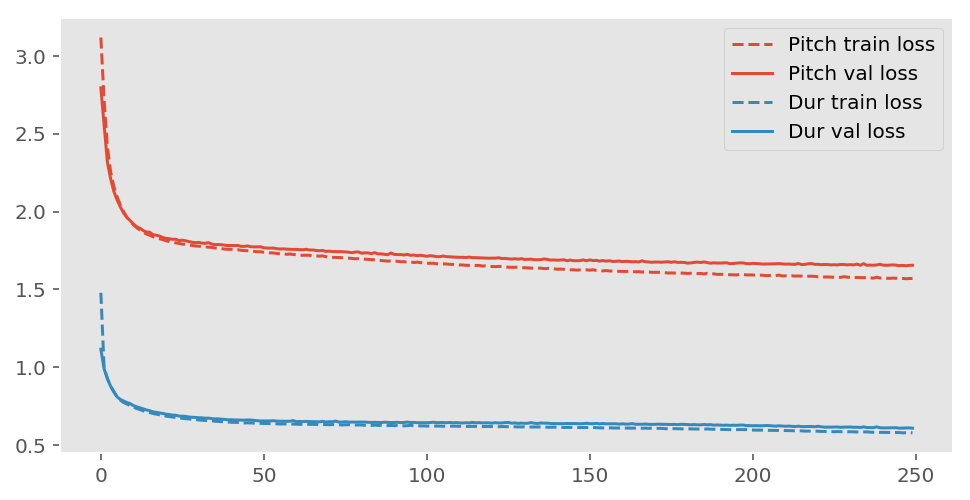

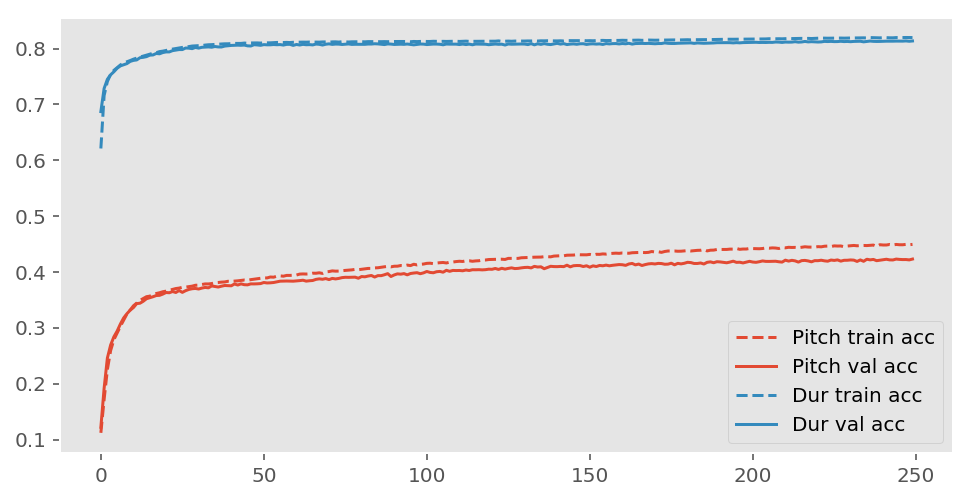

In [29]:
plotLearningCurves(historyRNN)

#### Train GRU model

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
XT (InputLayer)                 (None, 382, 19)      0                                            
__________________________________________________________________________________________________
XP (InputLayer)                 (None, 382, 53)      0                                            
__________________________________________________________________________________________________
MT (Masking)                    (None, 382, 19)      0           XT[0][0]                         
__________________________________________________________________________________________________
MP (Masking)                    (None, 382, 53)      0           XP[0][0]                         
__________________________________________________________________________________________________
MergeX (Co

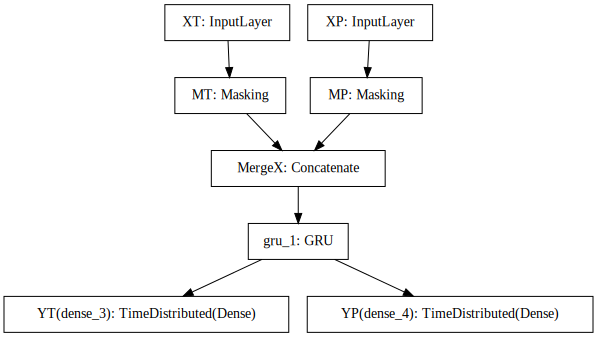

In [28]:
GRUmodel = buildModel(dictionaries, 
                      batch_length=num_timestamps,
                      activation='GRU',
                      N_layers = 1)
GRUmodel.summary()
SVG(model_to_dot(GRUmodel).create(prog='dot', format='svg'))

In [31]:
callbacks_list = [ModelCheckpoint('models/GRU_bestvalacc_1L128U_full.hdf5', monitor='val_YP_acc', save_best_only=True, mode='max')]
historyGRU = GRUmodel.fit([T_pad_trunc, P_pad_trunc], [shift_pad(T_pad_trunc), shift_pad(P_pad_trunc)], \
                       validation_split=0.2, batch_size=128, epochs=250, verbose=1, callbacks=callbacks_list)

Train on 3563 samples, validate on 891 samples
Epoch 1/250
3563/3563 [==============================] - 64s 18ms/step - loss: 3.0698 - YT_loss: 2.0574 - YP_loss: 3.4072 - YT_acc: 0.5826 - YP_acc: 0.1081 - val_loss: 2.4282 - val_YT_loss: 1.1961 - val_YP_loss: 2.8390 - val_YT_acc: 0.6879 - val_YP_acc: 0.1211
Epoch 2/250
3563/3563 [==============================] - 62s 18ms/step - loss: 2.3303 - YT_loss: 1.1015 - YP_loss: 2.7398 - YT_acc: 0.6911 - YP_acc: 0.1617 - val_loss: 2.2412 - val_YT_loss: 1.0486 - val_YP_loss: 2.6388 - val_YT_acc: 0.6896 - val_YP_acc: 0.1997
Epoch 3/250
3563/3563 [==============================] - 63s 18ms/step - loss: 2.0980 - YT_loss: 1.0145 - YP_loss: 2.4591 - YT_acc: 0.6938 - YP_acc: 0.2182 - val_loss: 2.0012 - val_YT_loss: 1.0042 - val_YP_loss: 2.3336 - val_YT_acc: 0.6929 - val_YP_acc: 0.2442
Epoch 4/250
3563/3563 [==============================] - 63s 18ms/step - loss: 1.9318 - YT_loss: 0.9614 - YP_loss: 2.2552 - YT_acc: 0.7066 - YP_acc: 0.2642 - val_loss: 1.

3563/3563 [==============================] - 109s 31ms/step - loss: 1.4650 - YT_loss: 0.6538 - YP_loss: 1.7355 - YT_acc: 0.8078 - YP_acc: 0.3915 - val_loss: 1.4855 - val_YT_loss: 0.6663 - val_YP_loss: 1.7586 - val_YT_acc: 0.8050 - val_YP_acc: 0.3856
Epoch 33/250
3563/3563 [==============================] - 91s 26ms/step - loss: 1.4609 - YT_loss: 0.6511 - YP_loss: 1.7308 - YT_acc: 0.8087 - YP_acc: 0.3936 - val_loss: 1.4819 - val_YT_loss: 0.6655 - val_YP_loss: 1.7540 - val_YT_acc: 0.8053 - val_YP_acc: 0.3870
Epoch 34/250
3563/3563 [==============================] - 94s 26ms/step - loss: 1.4564 - YT_loss: 0.6492 - YP_loss: 1.7255 - YT_acc: 0.8091 - YP_acc: 0.3953 - val_loss: 1.4777 - val_YT_loss: 0.6621 - val_YP_loss: 1.7496 - val_YT_acc: 0.8062 - val_YP_acc: 0.3885
Epoch 35/250
3563/3563 [==============================] - 98s 27ms/step - loss: 1.4528 - YT_loss: 0.6469 - YP_loss: 1.7215 - YT_acc: 0.8100 - YP_acc: 0.3962 - val_loss: 1.4753 - val_YT_loss: 0.6607 - val_YP_loss: 1.7468 - val_

3563/3563 [==============================] - 56s 16ms/step - loss: 1.3651 - YT_loss: 0.6104 - YP_loss: 1.6167 - YT_acc: 0.8170 - YP_acc: 0.4331 - val_loss: 1.4064 - val_YT_loss: 0.6300 - val_YP_loss: 1.6652 - val_YT_acc: 0.8115 - val_YP_acc: 0.4160
Epoch 64/250
3563/3563 [==============================] - 56s 16ms/step - loss: 1.3626 - YT_loss: 0.6103 - YP_loss: 1.6133 - YT_acc: 0.8170 - YP_acc: 0.4338 - val_loss: 1.4046 - val_YT_loss: 0.6298 - val_YP_loss: 1.6629 - val_YT_acc: 0.8113 - val_YP_acc: 0.4175
Epoch 65/250
3563/3563 [==============================] - 57s 16ms/step - loss: 1.3610 - YT_loss: 0.6095 - YP_loss: 1.6114 - YT_acc: 0.8171 - YP_acc: 0.4347 - val_loss: 1.4036 - val_YT_loss: 0.6287 - val_YP_loss: 1.6619 - val_YT_acc: 0.8118 - val_YP_acc: 0.4183
Epoch 66/250
3563/3563 [==============================] - 69s 19ms/step - loss: 1.3584 - YT_loss: 0.6080 - YP_loss: 1.6085 - YT_acc: 0.8175 - YP_acc: 0.4356 - val_loss: 1.4015 - val_YT_loss: 0.6274 - val_YP_loss: 1.6595 - val_Y

3563/3563 [==============================] - 85s 24ms/step - loss: 1.3036 - YT_loss: 0.5910 - YP_loss: 1.5411 - YT_acc: 0.8200 - YP_acc: 0.4590 - val_loss: 1.3696 - val_YT_loss: 0.6134 - val_YP_loss: 1.6217 - val_YT_acc: 0.8139 - val_YP_acc: 0.4318
Epoch 95/250
3563/3563 [==============================] - 71s 20ms/step - loss: 1.3016 - YT_loss: 0.5903 - YP_loss: 1.5386 - YT_acc: 0.8201 - YP_acc: 0.4601 - val_loss: 1.3685 - val_YT_loss: 0.6133 - val_YP_loss: 1.6203 - val_YT_acc: 0.8139 - val_YP_acc: 0.4322
Epoch 96/250
3563/3563 [==============================] - 67s 19ms/step - loss: 1.3004 - YT_loss: 0.5893 - YP_loss: 1.5374 - YT_acc: 0.8202 - YP_acc: 0.4607 - val_loss: 1.3687 - val_YT_loss: 0.6133 - val_YP_loss: 1.6205 - val_YT_acc: 0.8142 - val_YP_acc: 0.4314
Epoch 97/250
3563/3563 [==============================] - 80s 23ms/step - loss: 1.2983 - YT_loss: 0.5891 - YP_loss: 1.5348 - YT_acc: 0.8201 - YP_acc: 0.4616 - val_loss: 1.3676 - val_YT_loss: 0.6119 - val_YP_loss: 1.6195 - val_Y

3563/3563 [==============================] - 63s 18ms/step - loss: 1.2552 - YT_loss: 0.5704 - YP_loss: 1.4835 - YT_acc: 0.8233 - YP_acc: 0.4804 - val_loss: 1.3518 - val_YT_loss: 0.5978 - val_YP_loss: 1.6032 - val_YT_acc: 0.8166 - val_YP_acc: 0.4391
Epoch 126/250
3563/3563 [==============================] - 70s 20ms/step - loss: 1.2541 - YT_loss: 0.5699 - YP_loss: 1.4821 - YT_acc: 0.8232 - YP_acc: 0.4809 - val_loss: 1.3510 - val_YT_loss: 0.5971 - val_YP_loss: 1.6023 - val_YT_acc: 0.8167 - val_YP_acc: 0.4403
Epoch 127/250
3563/3563 [==============================] - 64s 18ms/step - loss: 1.2522 - YT_loss: 0.5684 - YP_loss: 1.4801 - YT_acc: 0.8235 - YP_acc: 0.4817 - val_loss: 1.3501 - val_YT_loss: 0.5954 - val_YP_loss: 1.6016 - val_YT_acc: 0.8172 - val_YP_acc: 0.4402
Epoch 128/250
3563/3563 [==============================] - 65s 18ms/step - loss: 1.2507 - YT_loss: 0.5675 - YP_loss: 1.4784 - YT_acc: 0.8233 - YP_acc: 0.4830 - val_loss: 1.3491 - val_YT_loss: 0.5957 - val_YP_loss: 1.6002 - va

3563/3563 [==============================] - 58s 16ms/step - loss: 1.2130 - YT_loss: 0.5500 - YP_loss: 1.4340 - YT_acc: 0.8258 - YP_acc: 0.4992 - val_loss: 1.3410 - val_YT_loss: 0.5818 - val_YP_loss: 1.5940 - val_YT_acc: 0.8192 - val_YP_acc: 0.4453
Epoch 157/250
3563/3563 [==============================] - 58s 16ms/step - loss: 1.2117 - YT_loss: 0.5493 - YP_loss: 1.4325 - YT_acc: 0.8260 - YP_acc: 0.4998 - val_loss: 1.3401 - val_YT_loss: 0.5822 - val_YP_loss: 1.5927 - val_YT_acc: 0.8190 - val_YP_acc: 0.4447
Epoch 158/250
3563/3563 [==============================] - 58s 16ms/step - loss: 1.2104 - YT_loss: 0.5494 - YP_loss: 1.4307 - YT_acc: 0.8259 - YP_acc: 0.5003 - val_loss: 1.3409 - val_YT_loss: 0.5816 - val_YP_loss: 1.5940 - val_YT_acc: 0.8193 - val_YP_acc: 0.4458
Epoch 159/250
3563/3563 [==============================] - 58s 16ms/step - loss: 1.2090 - YT_loss: 0.5491 - YP_loss: 1.4290 - YT_acc: 0.8259 - YP_acc: 0.5012 - val_loss: 1.3400 - val_YT_loss: 0.5815 - val_YP_loss: 1.5928 - va

3563/3563 [==============================] - 72s 20ms/step - loss: 1.1807 - YT_loss: 0.5420 - YP_loss: 1.3936 - YT_acc: 0.8273 - YP_acc: 0.5144 - val_loss: 1.3426 - val_YT_loss: 0.5783 - val_YP_loss: 1.5974 - val_YT_acc: 0.8194 - val_YP_acc: 0.4481
Epoch 188/250
3563/3563 [==============================] - 75s 21ms/step - loss: 1.1803 - YT_loss: 0.5417 - YP_loss: 1.3932 - YT_acc: 0.8271 - YP_acc: 0.5144 - val_loss: 1.3415 - val_YT_loss: 0.5787 - val_YP_loss: 1.5958 - val_YT_acc: 0.8193 - val_YP_acc: 0.4468
Epoch 189/250
3563/3563 [==============================] - 76s 21ms/step - loss: 1.1786 - YT_loss: 0.5419 - YP_loss: 1.3908 - YT_acc: 0.8273 - YP_acc: 0.5157 - val_loss: 1.3420 - val_YT_loss: 0.5778 - val_YP_loss: 1.5967 - val_YT_acc: 0.8196 - val_YP_acc: 0.4483
Epoch 190/250
3563/3563 [==============================] - 107s 30ms/step - loss: 1.1778 - YT_loss: 0.5413 - YP_loss: 1.3900 - YT_acc: 0.8273 - YP_acc: 0.5159 - val_loss: 1.3415 - val_YT_loss: 0.5783 - val_YP_loss: 1.5959 - v

3563/3563 [==============================] - 62s 18ms/step - loss: 1.1544 - YT_loss: 0.5365 - YP_loss: 1.3603 - YT_acc: 0.8279 - YP_acc: 0.5271 - val_loss: 1.3471 - val_YT_loss: 0.5760 - val_YP_loss: 1.6042 - val_YT_acc: 0.8190 - val_YP_acc: 0.4480
Epoch 219/250
3563/3563 [==============================] - 62s 18ms/step - loss: 1.1539 - YT_loss: 0.5364 - YP_loss: 1.3598 - YT_acc: 0.8279 - YP_acc: 0.5269 - val_loss: 1.3472 - val_YT_loss: 0.5761 - val_YP_loss: 1.6043 - val_YT_acc: 0.8193 - val_YP_acc: 0.4483
Epoch 220/250
3563/3563 [==============================] - 62s 17ms/step - loss: 1.1533 - YT_loss: 0.5364 - YP_loss: 1.3589 - YT_acc: 0.8279 - YP_acc: 0.5273 - val_loss: 1.3498 - val_YT_loss: 0.5766 - val_YP_loss: 1.6076 - val_YT_acc: 0.8192 - val_YP_acc: 0.4482
Epoch 221/250
3563/3563 [==============================] - 62s 17ms/step - loss: 1.1523 - YT_loss: 0.5366 - YP_loss: 1.3575 - YT_acc: 0.8277 - YP_acc: 0.5276 - val_loss: 1.3489 - val_YT_loss: 0.5767 - val_YP_loss: 1.6063 - va

3563/3563 [==============================] - 81s 23ms/step - loss: 1.1354 - YT_loss: 0.5344 - YP_loss: 1.3357 - YT_acc: 0.8282 - YP_acc: 0.5364 - val_loss: 1.3583 - val_YT_loss: 0.5755 - val_YP_loss: 1.6193 - val_YT_acc: 0.8195 - val_YP_acc: 0.4476
Epoch 250/250
3563/3563 [==============================] - 79s 22ms/step - loss: 1.1336 - YT_loss: 0.5339 - YP_loss: 1.3335 - YT_acc: 0.8282 - YP_acc: 0.5372 - val_loss: 1.3585 - val_YT_loss: 0.5760 - val_YP_loss: 1.6193 - val_YT_acc: 0.8194 - val_YP_acc: 0.4476


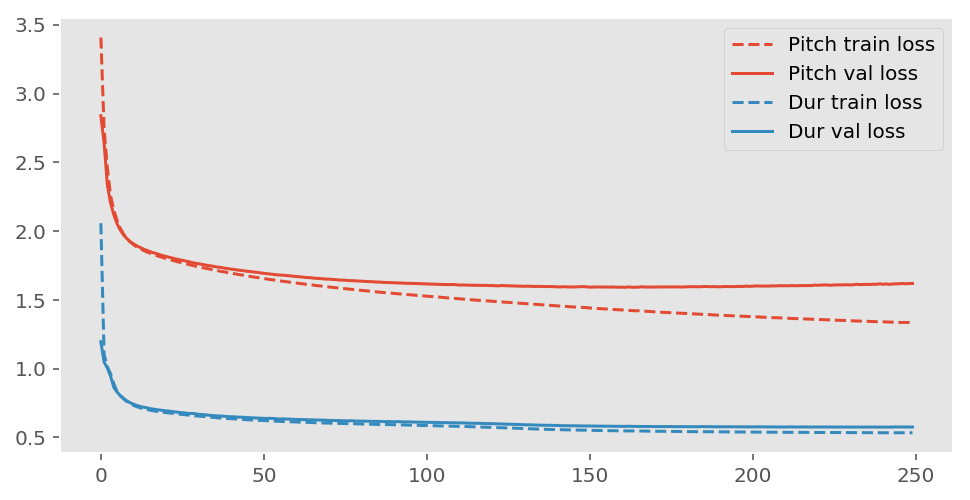

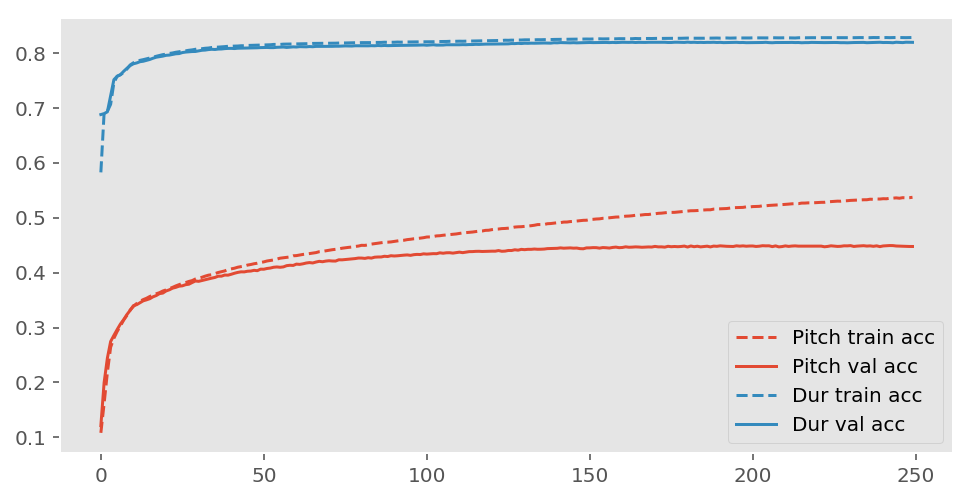

In [32]:
plotLearningCurves(historyGRU)

#### Compare learning curves

On a single plot, adapt the plotLearningCurves(History) function to compare the validation learning curves of the simpleRNN and GRU models. In other words, plot the validation loss vs epoch for pitch/duration for the simpleRNN and GRU models. Do the same for accuracies.

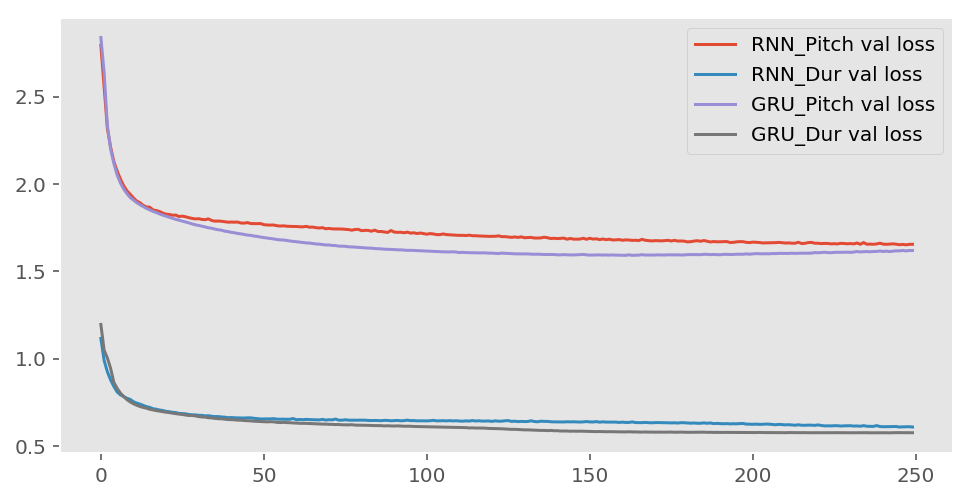

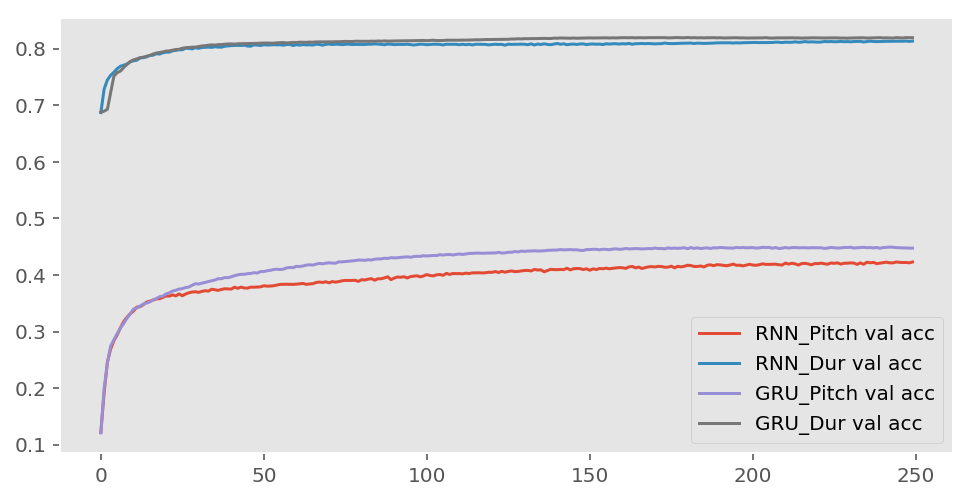

In [33]:
plotLearningCurves(historyRNN, historyGRU, labels =['RNN_', 'GRU_'])

**Question**: What are the best prediction accuracies you obtained? With which model?
    
**Answer**: Best accuracy predictions on validation data set are $\tilde{}  45\%$ for pitch and $\tilde{}  82\%$ for duration. They are obtained with GRU model, with 1 layer and 128 hidden units. (LSTM model wasn't trained-in that case it is likely that among RNN, GRU and LSTM, the last one would give the best accuracy).

**Question**: In a few sentences, comment on the plot comparing learning curves for the two activation function.
    
**Answer**: From the plot we see that for both duration and pitch, GRU activation function is working better (with bigger validation score). Considering duration, we observe that two models behave almoust the same (with slightly advantage of GRU), meaning that for this feature there is no significant difference in using one or the other model. On the other hand, when it comes to more complicated structures and dependencies, which is the case for pitch learning, we observe that there is a clear margin where GRU is learning better and gives better accuracy.

## Exercise 6: Visualizing the model
### Description

1. Using the model.predict and plotMelody functions, show the outputs of your best model when fed with 4 randomly selected melodies. Report the prediction accuracies as well.
2. For the same melodies, plot the hidden state evolution accross time steps. Construct a 2 dimensional matrix with the first dimension being time and the second the concatenation of all hidden unit activations and plot it using the provided `plotMelody` function. To get the hidden states of your network, you can modify the `buildModel` function so that you have another computation graph (another model with the same layers, but the output layer) returning you the hidden states. However, other approaches are equally valid.  
3. For each hidden unit $i$ and accross the entire dataset, compute the average absolute change in activation $\Delta A_i$. Be careful not to take masked timesteps into account. Plot the histogram (50 bins) of this average for the RNN and GRU models on the same figure.

### Solution

#### Plotting predicted values with hidden states matrix

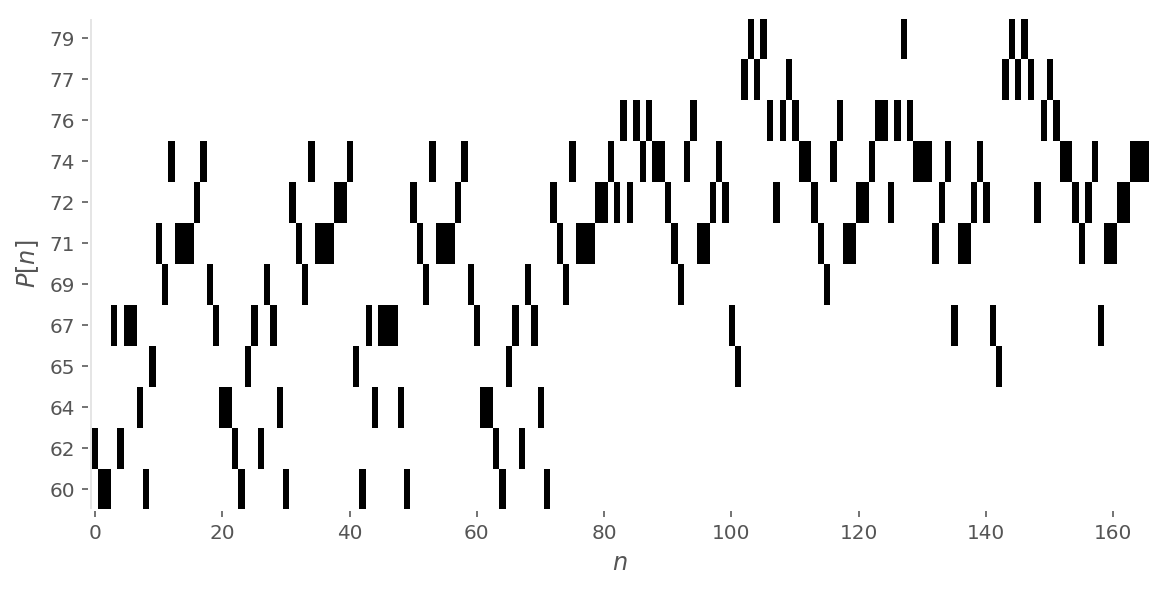

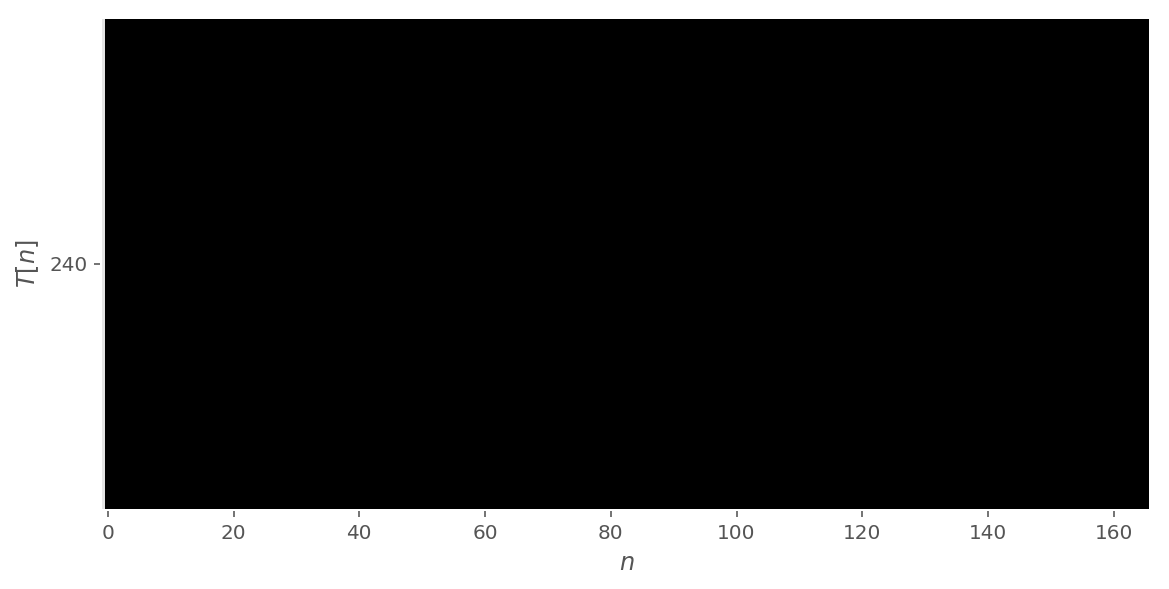

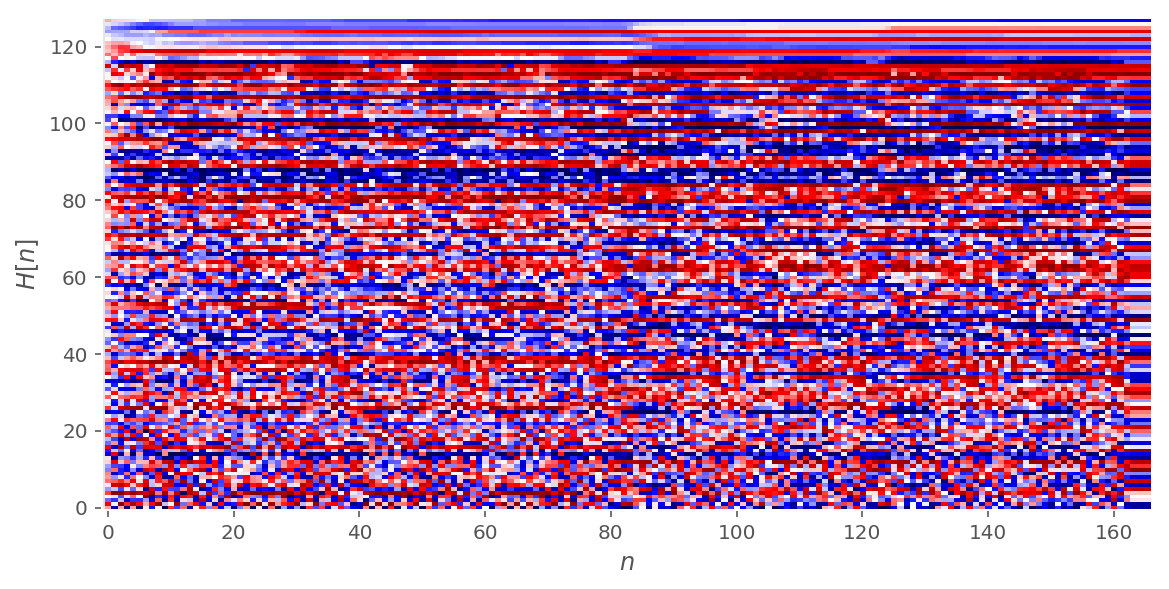

1/1 [==============================] - 0s 436ms/step
Pitch accuracy for this input is 0.5914635062217712
Duration accuracy for this input is 0.8719514608383179


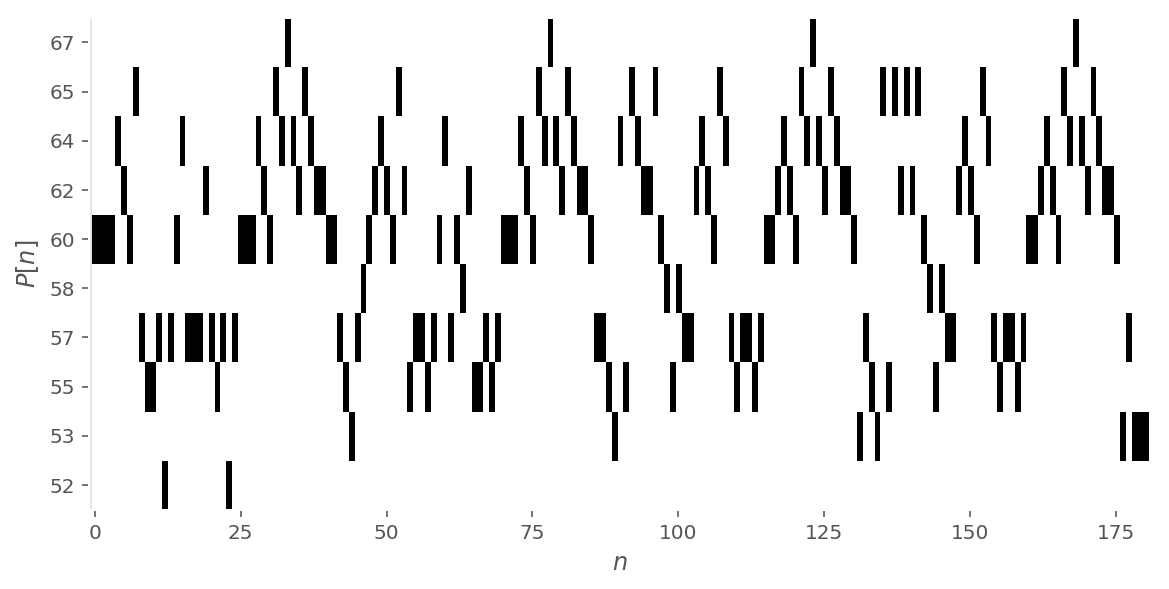

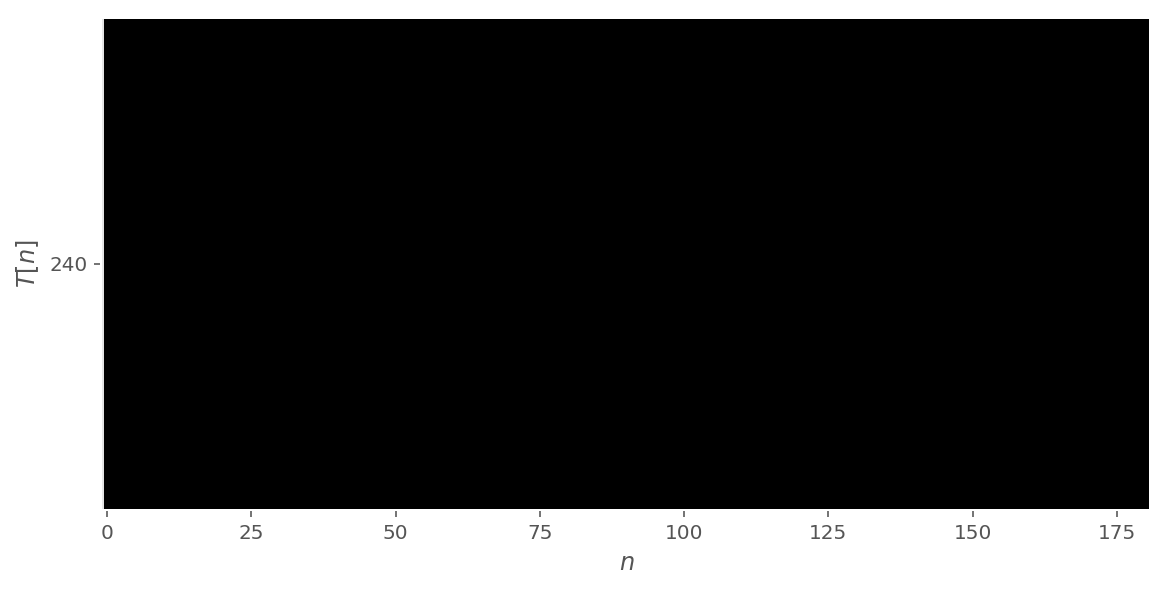

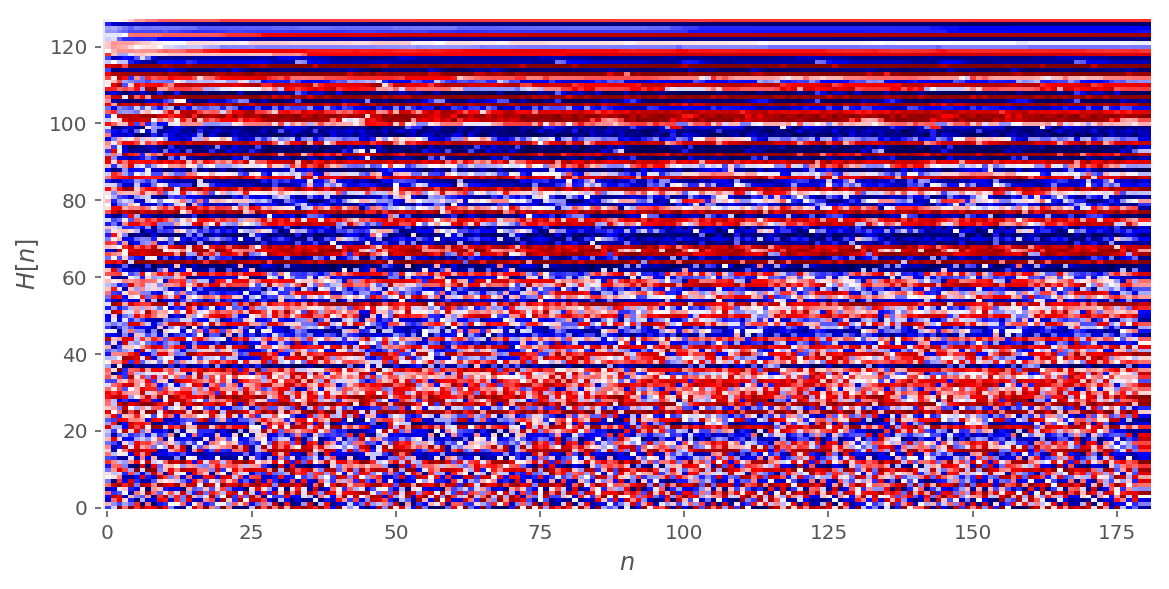

1/1 [==============================] - 0s 46ms/step
Pitch accuracy for this input is 0.3611111342906952
Duration accuracy for this input is 0.9500002264976501


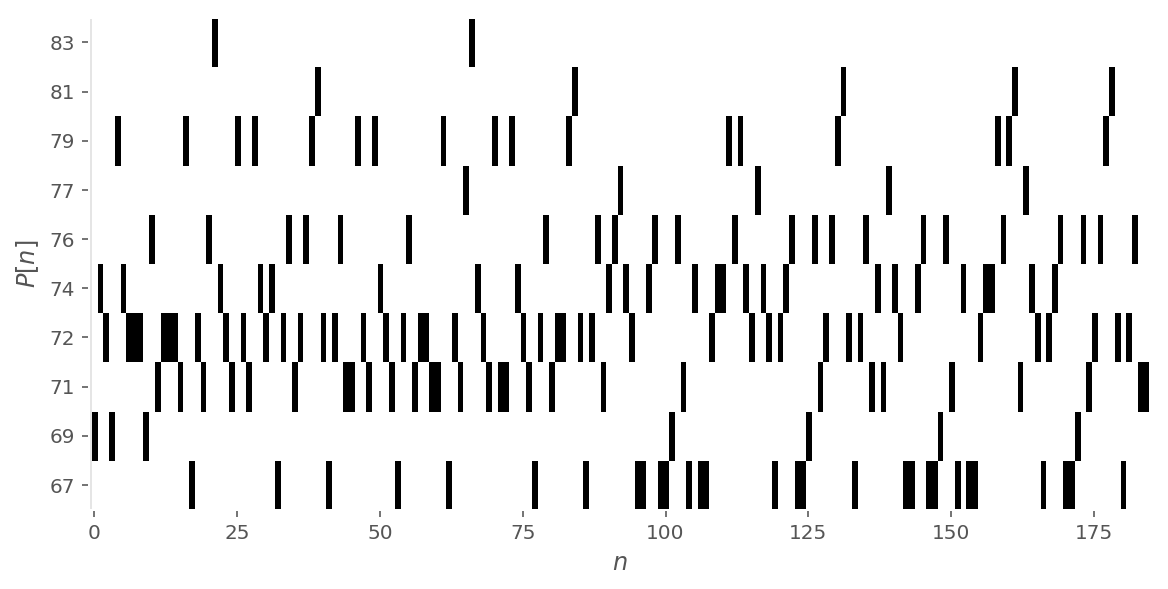

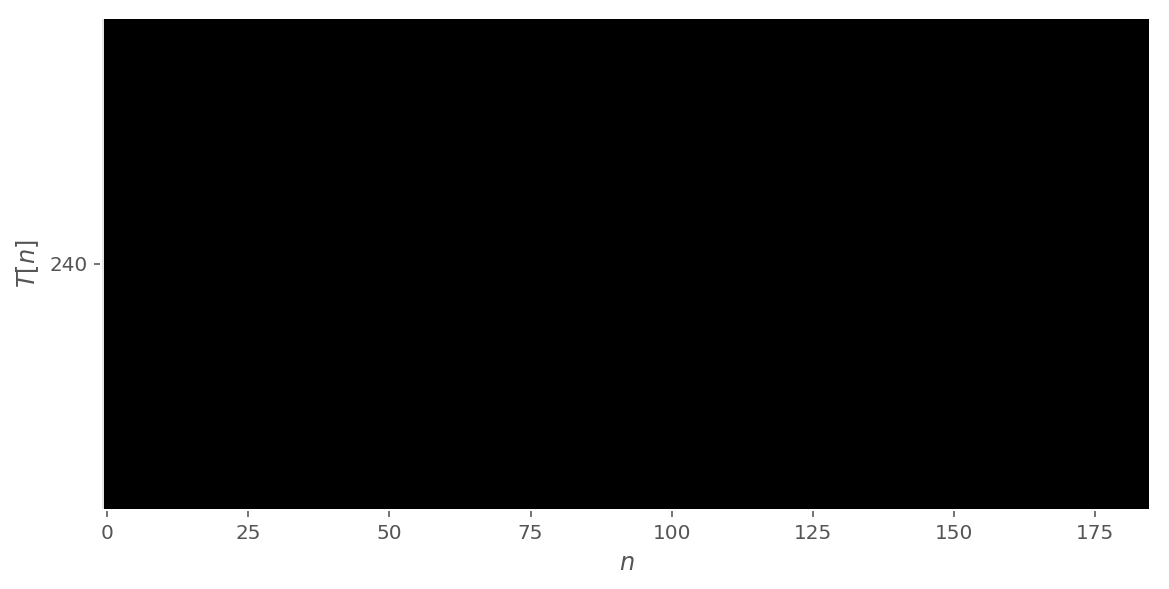

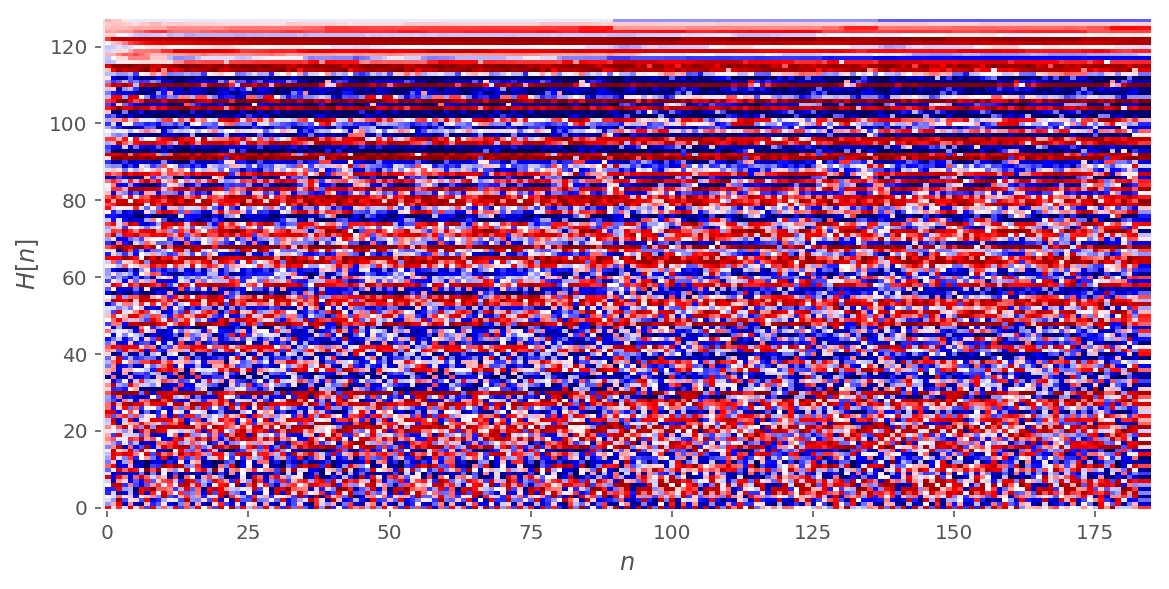

1/1 [==============================] - 0s 105ms/step
Pitch accuracy for this input is 0.19565218687057495
Duration accuracy for this input is 0.9619568586349487


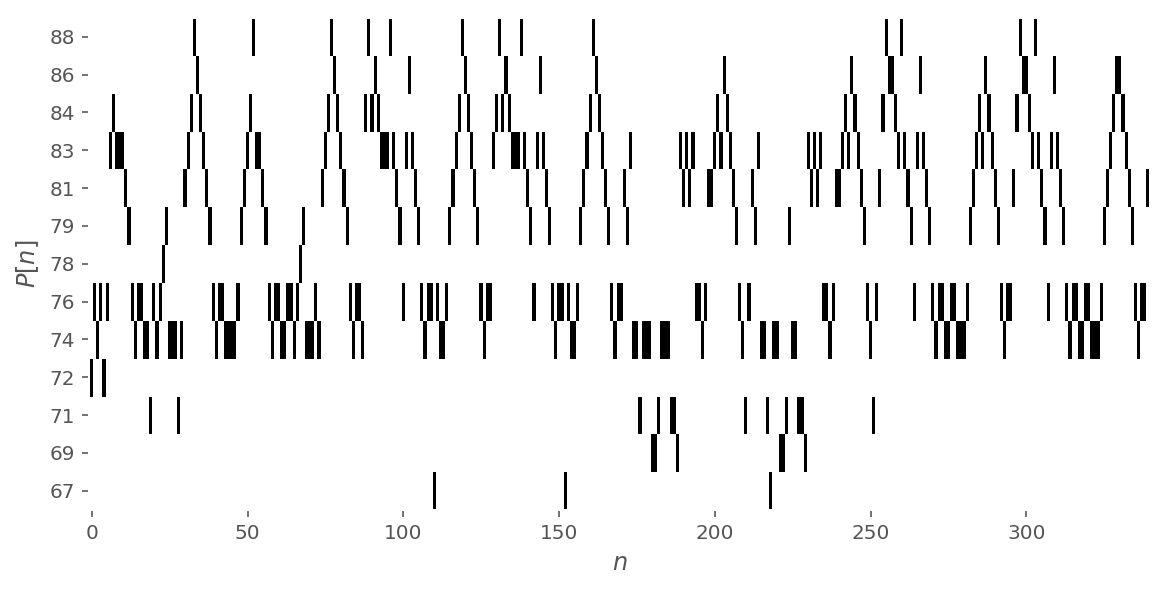

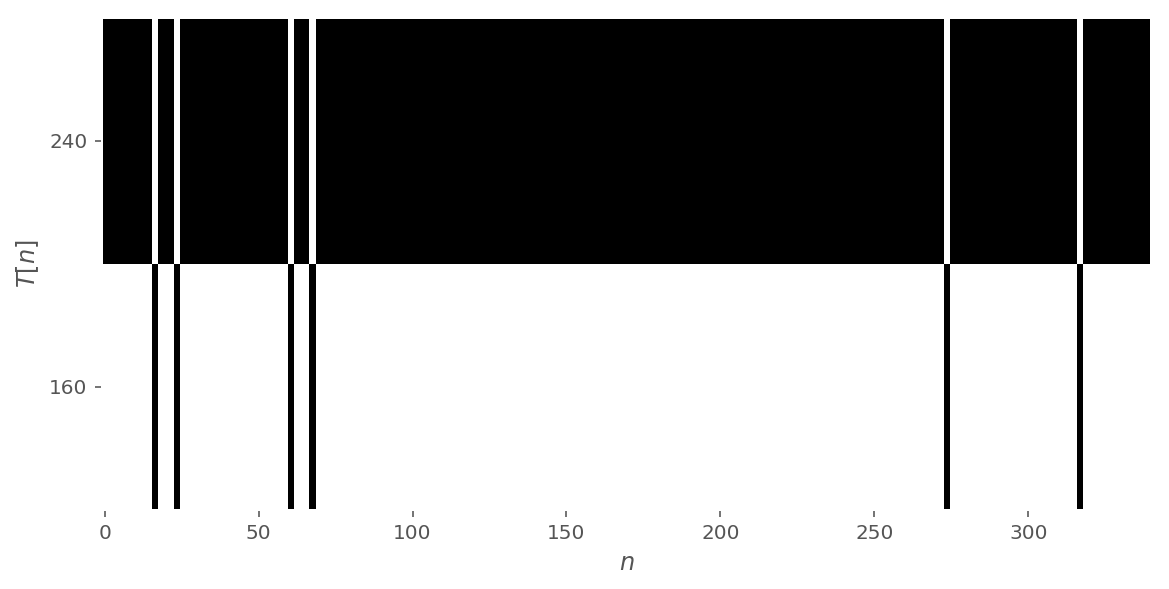

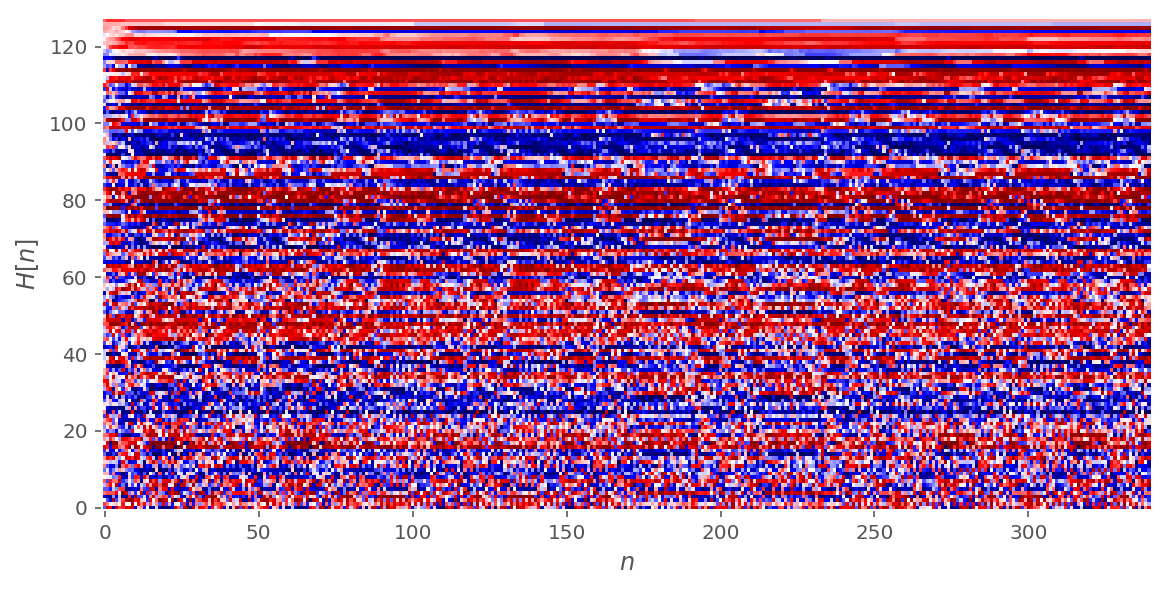

1/1 [==============================] - 0s 61ms/step
Pitch accuracy for this input is 0.6794111728668213
Duration accuracy for this input is 0.8794108033180237


In [7]:
indices = np.random.choice(range(T_pad_trunc.shape[0]), 4)
for ind in indices:
    x_T = np.expand_dims(T_pad_trunc[ind],axis=0)
    x_P = np.expand_dims(P_pad_trunc[ind],axis=0)
    T_pred, P_pred = best_model.predict([x_T, x_P])
    non_masked_cnt= np.unique(P_pred[0],axis=0).shape[0]
    
    output_P = np_utils.to_categorical(np.argmax(P_pred[0], axis=1), len(dictionaries['P']))
    output_T = np_utils.to_categorical(np.argmax(T_pred[0], axis=1), len(dictionaries['T']))
    output_P[non_masked_cnt:]=0
    output_T[non_masked_cnt:]=0
    true_output_P = np.expand_dims(shift_pad(T_pad_trunc)[ind],axis=0)
    true_output_T = np.expand_dims(shift_pad(P_pad_trunc)[ind], axis=0)
    
    #find hidden states    
    H = K.function(best_model.inputs, [best_model.layers[-3].output])([x_T, x_P])[0][0]
    
    plotMelody(output_P, output_T, dictionaries, H = H)
    scores = best_model.evaluate([x_T , x_P], [true_output_P, true_output_T])
    scores = dict(zip(best_model.metrics_names, scores))
    print('Pitch accuracy for this input is {}'.format(scores['YP_acc']))
    print('Duration accuracy for this input is {}'.format(scores['YT_acc']))

#### Plotting histogram of average absolute change in activation  ΔAi

In [8]:
diffGRU=0
diffRNN=0
for i, ind in enumerate(range(T_pad_trunc.shape[0])):
    if i%500==0: print('{}/{}'.format(i, T_pad_trunc.shape[0]))
    x_T = np.expand_dims(T_pad_trunc[ind],axis=0)
    x_P = np.expand_dims(P_pad_trunc[ind],axis=0)
    #find masked states    
        
    xlim = np.count_nonzero(T_pad_trunc[ind]) 
    H = K.function(best_model.inputs, [best_model.layers[-3].output])([x_T, x_P])[0][0]
    diffGRU += np.mean([[abs(j-i) for i,j in zip(H[:xlim-1,k], H[1:xlim,k])] for k in range(H.shape[1])], axis=1)
    
    H = K.function(best_modelRNN.inputs, [best_modelRNN.layers[-3].output])([x_T, x_P])[0][0]
    diffRNN += np.mean([[abs(j-i) for i,j in zip(H[:xlim-1,k], H[1:xlim,k])] for k in range(H.shape[1])], axis=1)
diffGRU = diffGRU/T_pad_trunc.shape[0]
diffRNN = diffRNN/T_pad_trunc.shape[0]
pickle.dump(diffGRU, open('results/diffGRU.p', 'wb'))
pickle.dump(diffRNN, open('results/diffRNN.p', 'wb'))

0/4454
500/4454
1000/4454
1500/4454
2000/4454
2500/4454
3000/4454
3500/4454
4000/4454


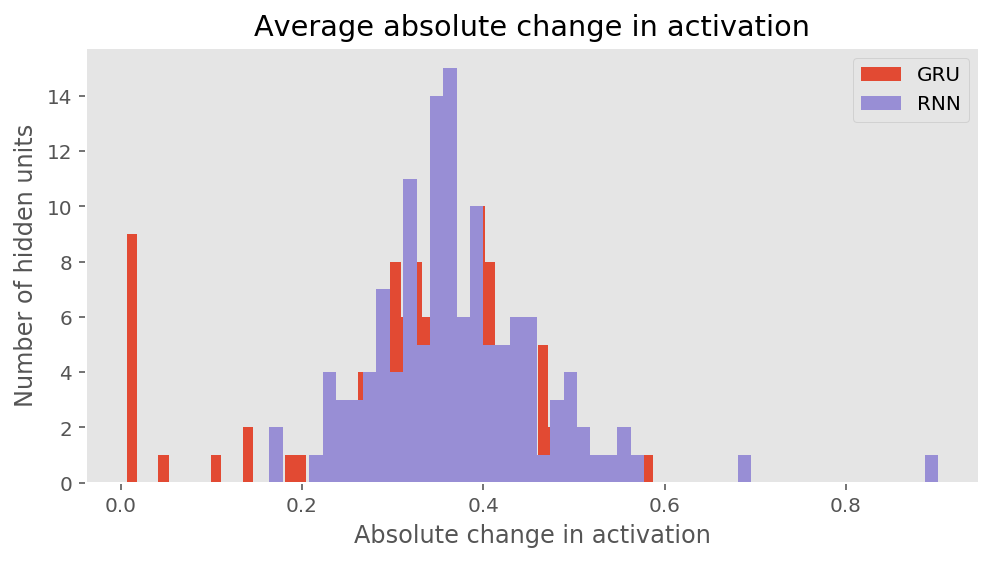

In [9]:
plt.figure(figsize=(8,4))
plt.hist(diffGRU, label='GRU', bins=50, color = c[0])
plt.hist(diffRNN, label='RNN', bins=50, color = c[2])
plt.ylabel("Number of hidden units")
plt.xlabel("Absolute change in activation")
plt.title("Average absolute change in activation")
plt.legend(loc='best')

**Question**: How does the hidden state dynamics explain the performance of the RNN vs GRU models? Explain in term of temporal dependencies and base your explanation on figures obtained in 6.2 and 6.3.
    
**Answer**: From the plot in 6.3 we observe that on average, absolute change in activation is bigger for RNN than for GRU model. Main difference between RNN and GRU model is that the latter can preserve some part of previous activation, i.e. the update is done with formula $h_{t}= h_{t-1}*(1-z_t) + z_t*(new\_activation)$. This makes it possible to keep long term temporal dependencies, by setting coefficient $z_t$ to a small value. Because of this, it is expected that absolute change in activation of hidden units is smaller for GRU's. From plot in 6.2. we observe that hidden units  preserve more or less their state throught time.

### Solution

#### Generate one song

In [29]:
def create_song(model, temperature):
    LENGTH = np.random.randint(10, T_pad_trunc[0].shape[0])
    X_P = np_utils.to_categorical(np.random.randint(1, len(dictionaries['P']), (1, P_pad_trunc[0].shape[0]))\
                                  , len(dictionaries['P']))
    X_T = np_utils.to_categorical(np.random.randint(1, len(dictionaries['T']), (1, T_pad_trunc[0].shape[0]))\
                                 ,len(dictionaries['T']))
    i=0
    while i<LENGTH:
        if i%100==0: print("{}/{} notes have been being computed".format(i, LENGTH))
        T_next, P_next = model.predict([X_T, X_P])
        X_T[0][i+1] = np_utils.to_categorical(sample (T_next[0][i], temperature), len(dictionaries['T']))
        X_P[0][i+1] = np_utils.to_categorical(sample (P_next[0][i], temperature), len(dictionaries['P']))
        i+=1
    xP = np.argmax(X_P[0], axis=1)
    xT = np.argmax(X_T[0], axis=1)
    return xP[:LENGTH], xT[:LENGTH]

In [36]:
temperature =1
xP, xT = create_song(best_model, temperature)
writeMIDI(xP, xT, dictionaries, 'results/temperature/GRU_1_temp1.mid')
music21.midi.translate.midiFilePathToStream('results/temperature/GRU_1_temp1.mid').show('midi')

0/304 notes have been being computed
100/304 notes have been being computed
200/304 notes have been being computed
300/304 notes have been being computed


In [31]:
temperature =0.5
xP, xT = create_song(best_model, temperature)
writeMIDI(xP, xT, dictionaries, 'results/temperature/GRU_1_temp05.mid')
music21.midi.translate.midiFilePathToStream('results/temperature/GRU_1_temp05.mid').show('midi')

0/171 notes have been being computed
100/171 notes have been being computed


In [38]:
temperature =1.5
xP, xT = create_song(best_model, temperature)
writeMIDI(xP, xT, dictionaries, 'results/temperature/GRU_1_temp15.mid')
music21.midi.translate.midiFilePathToStream('results/temperature/GRU_1_temp15.mid').show('midi')

0/324 notes have been being computed
100/324 notes have been being computed
200/324 notes have been being computed
300/324 notes have been being computed


#### Generate 32 melodies

In [20]:
#GRU
for i in range(32):
    print("{}-th song".format(i))
    xP, xT = create_song(best_model, temperature=1)
    writeMIDI(xP, xT, dictionaries, 'results/generated_songs/GRU/GRU_'+str(i)+'.mid')

0-th song
0/62 notes have been being computed
1-th song
0/326 notes have been being computed
100/326 notes have been being computed
200/326 notes have been being computed
300/326 notes have been being computed
2-th song
0/246 notes have been being computed
100/246 notes have been being computed
200/246 notes have been being computed
3-th song
0/154 notes have been being computed
100/154 notes have been being computed
4-th song
0/161 notes have been being computed
100/161 notes have been being computed
5-th song
0/21 notes have been being computed
6-th song
0/73 notes have been being computed
7-th song
0/47 notes have been being computed
8-th song
0/325 notes have been being computed
100/325 notes have been being computed
200/325 notes have been being computed
300/325 notes have been being computed
9-th song
0/162 notes have been being computed
100/162 notes have been being computed
10-th song
0/249 notes have been being computed
100/249 notes have been being computed
200/249 notes have

In [21]:
#RNN
for i in range(32):
    print("{}-th song".format(i))
    xP, xT = create_song(best_modelRNN, temperature=1)
    writeMIDI(xP, xT, dictionaries, 'results/generated_songs/RNN/RNN_'+str(i)+'.mid')

0-th song
0/49 notes have been being computed
1-th song
0/55 notes have been being computed
2-th song
0/318 notes have been being computed
100/318 notes have been being computed
200/318 notes have been being computed
300/318 notes have been being computed
3-th song
0/40 notes have been being computed
4-th song
0/54 notes have been being computed
5-th song
0/343 notes have been being computed
100/343 notes have been being computed
200/343 notes have been being computed
300/343 notes have been being computed
6-th song
0/216 notes have been being computed
100/216 notes have been being computed
200/216 notes have been being computed
7-th song
0/93 notes have been being computed
8-th song
0/301 notes have been being computed
100/301 notes have been being computed
200/301 notes have been being computed
300/301 notes have been being computed
9-th song
0/203 notes have been being computed
100/203 notes have been being computed
200/203 notes have been being computed
10-th song
0/363 notes have 

In [23]:
indicesGRU = np.random.choice(range(1, 32), 2)
indicesRNN = np.random.choice(range(1, 32), 2)

print('GRU')
for i in indicesGRU:
    music21.midi.translate.midiFilePathToStream('results/generated_songs/GRU/GRU_'+str(i)+'.mid').show('midi')
    
print('RNN')
for i in indicesRNN:
    music21.midi.translate.midiFilePathToStream('results/generated_songs/RNN/RNN_'+str(i)+'.mid').show('midi')

GRU


RNN


**Question**: What is the effect of the sampling temperature on the generated melodies?
    
**Answer**: For smaller temperature , i.e. 0.5 we obtain melody which sounds "correct", but it is very predictable (because we are taking notes with highest probability) and because of this, it is *boring* to listen. On the other hand, for higher temperature, i.e. 1.5 we observe that melody is more "artistic", with greater variety and unpredictability, therefore it is much more interesting to listen to. However, because of this, some maybe not very pleasent combination of notes may appear.

**Question**: Are the generated melodies from the RNN model different from the one generated by the GRU model? If yes, what are the main differences?

**Answer**: I observe that in general, melodies created with GRU sound *advanced* and it seems that they caught more structure than RNN. On the other hand, songs generated with RNN sound more simplistic and predictable, because they are not leaning on long term dependencies.

